In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Data import**

*Section 1*

In [20]:
teams = pd.read_csv("MDataFiles_Stage1/MTeams.csv")
seasons = pd.read_csv("MDataFiles_Stage1/MSeasons.csv")
tourney_seeds = pd.read_csv("MDataFiles_Stage1/MNCAATourneySeeds.csv")
reg_season_result = pd.read_csv("MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
tournament_result = pd.read_csv("MDataFiles_Stage1/MNCAATourneyCompactResults.csv")

*Section 2*

In [21]:
reg_season_gbg = pd.read_csv("MDataFiles_Stage1/MRegularSeasonDetailedResults.csv")
tournament_gbg = pd.read_csv("MDataFiles_Stage1/MNCAATourneyDetailedResults.csv")

*Section 3*

In [22]:
cities = pd.read_csv("MDataFiles_Stage1/Cities.csv")
game_cities = pd.read_csv("MDataFiles_Stage1/MGameCities.csv")

*Section 4*

In [23]:
rankings = pd.read_csv("MDataFiles_Stage1/MMasseyOrdinals.csv")

*Section 5*

In [24]:
events_2015 = pd.read_csv("MEvents2015.csv")
events_2016 = pd.read_csv("MEvents2016.csv")
events_2017 = pd.read_csv("MEvents2017.csv")
events_2018 = pd.read_csv("MEvents2018.csv")
events_2019 = pd.read_csv("MEvents2019.csv")

*Section 6*

In [635]:
sampleSub = pd.read_csv('MSampleSubmissionStage1_2020.csv')

<h3>EDA</h3>

<h3>Single season analysis</h3>

**Helper function**

In [25]:
"""
Separate regular season and tournament game results into separate seasons
"""
def yearSeparation(years):
    reg_season_sep = []
    tournament_sep = []
    for year in years:
        reg_season_sep.append(reg_season_result.loc[reg_season_result['Season'] == year])
        tournament_sep.append(tournament_result.loc[tournament_result['Season'] == year])
    #Sort tournament games by DayNum
    for i in range(len(years)):
        tournament_sep[i] = tournament_sep[i].sort_values('DayNum')
    return reg_season_sep, tournament_sep

In [1244]:
"""
Separate seed into separate seasons
"""
def seedSeparation(years):
    tournament_seeds = []
    for year in years:
        tournament_seeds.append(tourney_seeds.groupby(['Season']).get_group(year))
    return tournament_seeds

In [32]:
"""
Merge won and lost team seeds into tournament_sep
"""
def mergeSeedTourney(tourney_combined,years):
    tournament_seeds = seedSeparation(years)
    for i in range(len(years)):
        winning_teams = tourney_combined[i].merge(tournament_seeds[i][['TeamID', 'Seed']], left_on='WTeamID',right_on='TeamID').drop('TeamID', axis=1).rename(columns={"Seed":"WTeamSeed"})
        tourney_combined[i] = winning_teams.merge(tournament_seeds[i][['TeamID','Seed']], left_on='LTeamID', right_on='TeamID').drop('TeamID',axis=1).rename(columns={'Seed':'LTeamSeed'})

In [910]:
"""
Strip seed into pure integer
"""
def stripSeedtoInt(years, tourney=True):
    if tourney:
        for j in range(len(years)):
            tournament_sep[j]['WTeamSeedPure'] = tournament_sep[j]['WTeamSeed']
            tournament_sep[j]['LTeamSeedPure'] = tournament_sep[j]['LTeamSeed']
            for i in (tournament_sep[j].index):
                tournament_sep[j]['WTeamSeedPure'][i] = tournament_sep[j]['WTeamSeed'][i][1:3]
                tournament_sep[j]['LTeamSeedPure'][i] = tournament_sep[j]['LTeamSeed'][i][1:3]
    else:
        for j in range(len(years)):
            reg_season_sep[j]['WTeamSeedPure'] = reg_season_sep[j]['WTeamSeed']
            reg_season_sep[j]['LTeamSeedPure'] = reg_season_sep[j]['LTeamSeed']
            for i in (tournament_sep[j].index):
                reg_season_sep[j]['WTeamSeedPure'][i] = reg_season_sep[j]['WTeamSeed'][i][1:3]
                reg_season_sep[j]['LTeamSeedPure'][i] = reg_season_sep[j]['LTeamSeed'][i][1:3]

In [511]:
"""
This function create ID and label for each game by default
Optional parameters to calculate Seed_diff and ranking_diff is available
"""
def featureAddition(dataset,seed=None, rank=None, elo=None):
    for index, row in dataset.iterrows():
        lower_ID = row['WTeamID']
        higher_ID = row['LTeamID']
        if seed != None:
            seed_diff = int(row['WTeamSeedPure']) - int(row['LTeamSeedPure'])
        if rank != None:
            ranking_diff = int(row['WRanking']) - int(row['LRanking'])
        if elo != None:
            lower_elo = row['w_elo']
            higher_elo = row['l_elo']

        if lower_ID > higher_ID:
            tmp = lower_ID
            lower_ID = higher_ID
            higher_ID = tmp
            if elo != None:
                tmp_elo = lower_elo
                lower_elo = higher_elo
                higher_elo = tmp_elo
            if rank != None:
                ranking_diff = int(row['LRanking']) - int(row['WRanking'])
            if seed != None:
                seed_diff = int(row['LTeamSeedPure']) - int(row['WTeamSeedPure'])
        #Id
        dataset.loc[index, 'ID'] = (str(row['Season']) + "_" + str(lower_ID) + "_" + str(higher_ID))
        #Label
        if lower_ID == row['WTeamID']:
            dataset.loc[index,'lower_win'] = 1
        else:
            dataset.loc[index,'lower_win'] = 0
        #Seed diff
        if seed != None:
            dataset.loc[index, 'Seed_diff'] = seed_diff
        #Ranking diff
        if rank != None:
            dataset.loc[index, 'Ranking_diff'] = ranking_diff
        if elo != None:
            dataset.loc[index, 'lower_elo'] = lower_elo
            dataset.loc[index,'higher_elo'] = higher_elo

In [12]:
"""
Calculate rankings of each team in seasons given
"""
def calcRankings(years):
    rankings = {}
    rank_list = []
    last_day_ranking = rankings.loc[(rankings['RankingDayNum'] == 133)&(rankings['Season'] >= years[0])].sort_values(['Season','OrdinalRank'])
    for season in years:
        rankings['last_day_ranking_' + str(season)] = last_day_ranking[last_day_ranking['Season'] == season]
        rank_list.append(calcRankList(rankings['last_day_ranking_' + str(season)]))
    return rank_list

In [13]:
"""
Calculate favored team in single season
"""
def calcRankList(single_season_ranking):
    favored_team = []
    for rank in range(int(single_season_ranking['OrdinalRank'].tail(1).values) + 1):
        specific_rank = single_season_ranking[single_season_ranking['OrdinalRank'] == rank]
        value_count = specific_rank['TeamID'].value_counts()
        for index in value_count.index:
            if index not in favored_team:
                favored_team.append(index)
        print('Rank {} done'.format(rank))
    return favored_team

In [931]:
reg_season_sep, tournament_sep = yearSeparation(range(2010,2020))

In [932]:
mergeSeedTourney(tournament_sep, range(2010,2020))

In [39]:
stripSeedtoInt(tournament_sep)

d:\python demo\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
d:\python demo\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [43]:
for tourney in tournament_sep:
    featureAddition(tourney, seed=True)

In [56]:
for reg_season in reg_season_sep:
    featureAddition(reg_season)

d:\python demo\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
d:\python demo\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
tournament_sep[0].head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamSeed,LTeamSeed,WTeamSeedPure,LTeamSeedPure,ID,lower_win,Seed_diff
0,2014,134,1107,71,1291,64,N,0,X16a,X16b,16,16,2014_1107_1291,1.0,0.0
1,2014,134,1301,74,1462,59,N,0,Y12a,Y12b,12,12,2014_1301_1462,1.0,0.0
2,2014,135,1142,81,1411,69,N,0,Y16a,Y16b,16,16,2014_1142_1411,1.0,0.0
3,2014,135,1397,78,1234,65,N,1,Y11b,Y11a,11,11,2014_1234_1397,0.0,0.0
4,2014,137,1397,86,1269,67,N,0,Y11b,Y06,11,06,2014_1269_1397,0.0,-5.0
5,2014,139,1397,83,1273,63,N,0,Y11b,Y14,11,14,2014_1273_1397,0.0,3.0
6,2014,136,1458,75,1110,35,N,0,Z02,Z15,02,15,2014_1110_1458,0.0,13.0
7,2014,138,1458,85,1332,77,N,0,Z02,Z07,02,07,2014_1332_1458,0.0,5.0
8,2014,143,1458,69,1124,52,N,0,Z02,Z06,02,06,2014_1124_1458,0.0,4.0
9,2014,145,1458,64,1112,63,N,1,Z02,Z01,02,01,2014_1112_1458,0.0,-1.0


In [930]:
reg_season_sep[0]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,margin,w_elo,l_elo
108122,2010,7,1143,75,1293,70,H,0,5,1769.203473,1507.635282
108123,2010,7,1314,88,1198,72,H,0,16,2131.479004,1350.442032
108124,2010,7,1326,100,1108,60,H,0,40,1860.088983,1035.815934
108125,2010,7,1393,75,1107,43,H,0,32,1903.931313,1364.162567
108126,2010,9,1143,95,1178,61,H,0,34,1770.783743,1344.007965
...,...,...,...,...,...,...,...,...,...,...,...
113380,2010,131,1452,60,1207,58,N,0,2,1969.171995,1910.629219
113381,2010,132,1181,65,1210,61,N,0,4,2072.388172,1798.200028
113382,2010,132,1246,75,1280,74,N,1,1,1959.735388,1826.920113
113383,2010,132,1326,90,1278,61,N,0,29,1944.062796,1807.166676


<h3>Game by Game analysis</h3>

In [1224]:
"""
Calculate offensive and defensive efficiency of a team throughout the season
"""
def calcEfficiency(dataset,teamID):
    game_won = dataset.loc[dataset['WTeamID'] == teamID]
    game_lost = dataset.loc[dataset['LTeamID'] == teamID]
    total_score = 0
    total_score_allowed = 0
    total_FGA = 0
    total_OR = 0
    total_TO = 0
    total_FTA = 0
    for index, row in game_won.iterrows():
        total_score = total_score + row['WScore']
        total_score_allowed = total_score_allowed + row['LScore']
        total_FGA = total_FGA + row['WFGA']
        total_OR = total_OR + row['WOR']
        total_TO = total_TO + row['WTO']
        total_FTA = total_FTA + row['WFTA']
    for index, row in game_lost.iterrows():
        total_score = total_score + row['LScore']
        total_score_allowed = total_score_allowed + row['WScore']
        total_FGA = total_FGA + row['LFGA']
        total_OR = total_OR + row['LOR']
        total_TO = total_TO + row['LTO']
        total_FTA = total_FTA + row['LFTA']
    poss = total_FGA - total_OR + total_TO + 0.4 * total_FTA
    if teamID != 1309:
        oeff = total_score / poss
        deff = total_score_allowed / poss
        return oeff, deff
    else:
        return 0,0

In [1193]:
"""
Calculate efficiency for all teams in a single season
"""
def applyEff_team(dataset, year):
    OEff = []
    DEff = []
    for team, lastYear, firstYear in zip(teams['TeamID'],teams['LastD1Season'], teams['FirstD1Season']):
        if (firstYear <= year) and (lastYear >= year):
            OEff_score, DEff_score = calcEfficiency(dataset,team)
            OEff.append(OEff_score)
            DEff.append(DEff_score)
        else:
            OEff.append('NaN')
            DEff.append('NaN')
    return OEff, DEff

In [1194]:
"""
Get teamID based on gameID
"""
def getTeam(dataset,index):
    firstT = dataset['ID'][index][5:9]
    secondT = dataset['ID'][index][10:14]
    return firstT, secondT

In [1195]:
"""
Apply efficiency of teams into a single season dataset
"""
def applyEff_season(dataset, season):
    for index, row in dataset.iterrows():
        firstT, secondT = getTeam(dataset, index)
        dataset.loc[index,'Team1_OEff'] = round(float(teams[teams['TeamID'] == int(firstT)]['Offensive_Eff_' + str(season)].values) * 100,1)
        dataset.loc[index,'Team1_DEff'] = round(float(teams[teams['TeamID'] == int(firstT)]['Defensive_Eff_' + str(season)].values) * 100,1)
        dataset.loc[index,'Team2_OEff'] = round(float(teams[teams['TeamID'] == int(secondT)]['Offensive_Eff_' + str(season)].values) * 100,1)
        dataset.loc[index,'Team2_DEff'] = round(float(teams[teams['TeamID'] == int(secondT)]['Defensive_Eff_' + str(season)].values) * 100,1)

In [1196]:
"""
Generate dataset for training
"""
def featureSelection(dataset, feature):
    train_set = dataset[feature]
    return train_set

In [1197]:
def generateGbgSeparation(years):
    reg_gbg = []
    for year in years:
        reg_gbg.append(reg_season_gbg[reg_season_gbg['Season'] == year])
    return reg_gbg

In [1198]:
reg_gbg = generateGbgSeparation(range(2010,2020))

In [1223]:
reg_season_sep[1][reg_season_sep[1]['WTeamID']==1309]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,margin,w_elo,l_elo,ID,lower_win,seed_diff,Team1_OEff,Team1_DEff,Team2_OEff,Team2_DEff


In [1225]:
for reg, year in zip(reg_gbg,range(2010,2020)):
    OEff, DEff = applyEff_team(reg, year)
    teams['Offensive_Eff_' + str(year)] = OEff
    teams['Defensive_Eff_' + str(year)] = DEff

In [1226]:
for reg, year in zip(reg_season_sep, range(2010, 2020)):
    applyEff_season(reg, year)
    print(str(year) + 'done!')

2010done!
2011done!
2012done!
2013done!
2014done!
2015done!


d:\python demo\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


2016done!
2017done!
2018done!
2019done!


In [1228]:
for tourney, year in zip(tournament_sep, range(2010,2020)):
    applyEff_season(tourney, year)
    print(str(year) + ' done!')

2010 done!
2011 done!
2012 done!
2013 done!
2014 done!
2015 done!
2016 done!
2017 done!
2018 done!
2019 done!


In [1233]:
features = ['ID','lower_win','Team1_OEff','Team1_DEff','Team2_OEff','Team2_DEff']
train_reg_2010 = featureSelection(reg_season_sep[0],features)
train_reg_2011 = featureSelection(reg_season_sep[1],features)
train_reg_2012 = featureSelection(reg_season_sep[2],features)
train_reg_2013 = featureSelection(reg_season_sep[3],features)
train_reg_2014 = featureSelection(reg_season_sep[4],features)
train_reg_2015 = featureSelection(reg_season_sep[5],features)
train_reg_2016 = featureSelection(reg_season_sep[6],features)
train_reg_2017 = featureSelection(reg_season_sep[7],features)
train_reg_2018 = featureSelection(reg_season_sep[8],features)
train_reg_2019 = featureSelection(reg_season_sep[9],features)

In [1234]:
train_2010 = featureSelection(tournament_sep[0],features)
train_2011 = featureSelection(tournament_sep[1],features)
train_2012 = featureSelection(tournament_sep[2],features)
train_2013 = featureSelection(tournament_sep[3],features)
train_2014 = featureSelection(tournament_sep[4],features)
train_2015 = featureSelection(tournament_sep[5],features)
train_2016 = featureSelection(tournament_sep[6],features)
train_2017 = featureSelection(tournament_sep[7],features)
train_2018 = featureSelection(tournament_sep[8],features)
train_2019 = featureSelection(tournament_sep[9],features)

*Feature Decrease*

In [1235]:
for train in [train_reg_2010, train_reg_2011, train_reg_2012, train_reg_2013, train_reg_2014, train_reg_2015,train_reg_2016,train_reg_2017,train_reg_2018,train_reg_2019, train_2010, train_2011, train_2012, train_2013, train_2014, train_2015, train_2016, train_2017, train_2018, train_2019]:
    train['OEff_diff'] = train['Team1_OEff'] - train['Team2_OEff']
    train['DEff_diff'] = train['Team1_DEff'] - train['Team2_DEff']

d:\python demo\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\python demo\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1287]:
reg_all_feat = []
tourney_all_feat = []
reg = [train_reg_2010, train_reg_2011, train_reg_2012, train_reg_2013, train_reg_2014, train_reg_2015,train_reg_2016,train_reg_2017,train_reg_2018,train_reg_2019]
tourney = [train_2010, train_2011, train_2012, train_2013, train_2014, train_2015, train_2016, train_2017, train_2018, train_2019]
reg_elo = [train_reg_2010_elo, train_reg_2011_elo, train_reg_2012_elo, train_reg_2013_elo, train_reg_2014_elo, train_reg_2015_elo, train_reg_2016_elo, train_reg_2017_elo, train_reg_2018_elo, train_reg_2019_elo]
tourney_elo = [train_2010_elo, train_2011_elo, train_2012_elo, train_2013_elo, train_2014_elo, train_2015_elo, train_2016_elo, train_2017_elo, train_2018_elo, train_2019_elo]
for i in range(len(reg)):
    reg_all_feat.append(reg_elo[i].merge(reg[i][['OEff_diff','DEff_diff', 'ID']], left_on='ID', right_on='ID'))
    tourney_all_feat.append(tourney_elo[i].merge(tourney[i][['OEff_diff','DEff_diff', 'ID']], left_on='ID', right_on='ID'))

In [1561]:
reg_all_feat[0]
tourney_all_feat[8]

,ID,lower_win,seed_diff,lower_elo,higher_elo,OEff_diff,DEff_diff
0,2018_1254_1347,0.0,0.0,1352.098023,1410.253837,1.8,5.3
1,2018_1382_1417,1.0,0.0,1764.661141,1882.663614,0.0,-2.3
2,2018_1113_1393,0.0,0.0,1739.417526,1795.949333,11.3,4.4
3,2018_1393_1395,1.0,5.0,1795.949333,1814.770267,-12.8,-7.4
4,2018_1277_1393,0.0,-8.0,1975.817730,1795.949333,14.6,-4.8
...,...,...,...,...,...,...,...
62,2018_1166_1243,0.0,-1.0,1865.009175,1825.106594,5.4,0.1
63,2018_1243_1420,1.0,-7.0,1825.106594,1405.549180,3.0,-1.6
64,2018_1243_1246,1.0,4.0,1825.106594,1998.592934,-1.7,0.8
65,2018_1155_1308,1.0,-7.0,1850.108604,1726.189839,-0.1,4.6


<h3>Elo Score</h3>

In [384]:
base_elo = 1600
elo_mess = reg_season_result
team_ids = set(elo_mess.WTeamID).union(set(elo_mess.LTeamID))
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [365]:
K = 20
HOME_ADVANTAGE = 100

In [366]:
#This calculate the margin of victory
elo_mess['margin'] = elo_mess.WScore - elo_mess.LScore

In [367]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [368]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in elo_mess.itertuples():
    
    # Get key data from current row
    w = row.WTeamID
    l = row.LTeamID
    margin = row.margin
    wloc = row.WLoc
    
    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [370]:
elo_mess['w_elo'] = w_elo
elo_mess['l_elo'] = l_elo

In [372]:
np.mean(-np.log(preds))

0.5329642499754852

In [417]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'Season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [418]:
df_list = [final_elo_per_season(elo_mess, id) for id in team_ids]
season_elos = pd.concat(df_list)

In [424]:
elo_filtered = season_elos[season_elos['Season'] == 2010]
elo_filtered

,team_id,Season,season_elo
113297,1102,2010,1422.51
113370,1103,2010,1674.45
113332,1104,2010,1734.78
113276,1105,2010,1147.88
113322,1106,2010,1367.85
...,...,...,...
113229,1460,2010,1671.36
113244,1461,2010,1451
113372,1462,2010,1887.02
113102,1463,2010,1322.81


In [516]:
reg_season_elo, tournament_elo = yearSeparation(range(2010, 2020))
for i in range(2010, 2020):
    featureAddition(reg_season_elo[i-2010])
    featureAddition(tournament_elo[i-2010])

d:\python demo\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
d:\python demo\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [517]:
for year in range(2010, 2020):
    elo_filtered = season_elos[season_elos['Season'] == year]
    a = tournament_elo[year-2010].merge(elo_filtered, left_on='WTeamID', right_on='team_id').drop(['team_id'], axis=1).rename(columns={'season_elo':'w_elo'})
    tournament_elo[year-2010] = a.merge(elo_filtered, left_on='LTeamID', right_on='team_id').drop(['team_id'], axis=1).rename(columns={'season_elo':'l_elo'})

In [1562]:
reg_season_sep[0]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,margin,w_elo,l_elo,ID,lower_win,seed_diff,Team1_OEff,Team1_DEff,Team2_OEff,Team2_DEff
108122,2010,7,1143,75,1293,70,H,0,5,1769.203473,1507.635282,2010_1143_1293,1.0,-5.0,116.0,101.8,115.8,92.9
108123,2010,7,1314,88,1198,72,H,0,16,2131.479004,1350.442032,2010_1198_1314,0.0,0.0,99.1,113.3,105.1,101.1
108124,2010,7,1326,100,1108,60,H,0,40,1860.088983,1035.815934,2010_1108_1326,0.0,-2.0,82.0,110.9,116.0,95.6
108125,2010,7,1393,75,1107,43,H,0,32,1903.931313,1364.162567,2010_1107_1393,0.0,-1.0,96.9,106.8,116.4,95.6
108126,2010,9,1143,95,1178,61,H,0,34,1770.783743,1344.007965,2010_1143_1178,1.0,8.0,116.0,101.8,103.8,99.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113380,2010,131,1452,60,1207,58,N,0,2,1969.171995,1910.629219,2010_1207_1452,0.0,1.0,112.4,99.9,115.3,100.8
113381,2010,132,1181,65,1210,61,N,0,4,2072.388172,1798.200028,2010_1181_1210,1.0,-9.0,118.4,93.7,104.8,95.5
113382,2010,132,1246,75,1280,74,N,1,1,1959.735388,1826.920113,2010_1246_1280,1.0,1.0,115.1,94.8,107.9,95.9
113383,2010,132,1326,90,1278,61,N,0,29,1944.062796,1807.166676,2010_1278_1326,0.0,9.0,112.1,98.4,116.0,95.6


In [914]:
for year in range(2010, 2020):
    featureAddition(reg_season_elo[year-2010], elo=True)

d:\python demo\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


KeyboardInterrupt: 

In [975]:
features_elo = ['ID','lower_win','seed_diff','lower_elo','higher_elo']
train_elo_reg = {}
train_elo_tourney = {}
for year in range(2010, 2020):
    train_elo_reg['train_' + str(year) + "_elo"] = featureSelection(reg_season_elo[year-2010],features_elo) 
    train_elo_tourney['train_' + str(year) + "_tourney_elo"] = featureSelection(tournament_elo[year-2010],features_elo) 

<h3>Modeling and Training</h3>

In [976]:
reg_season_elo[0]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,margin,w_elo,l_elo,ID,lower_win,lower_elo,higher_elo,seed_diff
108122,2010,7,1143,75,1293,70,H,0,5,1769.203473,1507.635282,2010_1143_1293,1.0,1769.203473,1507.635282,-5.0
108123,2010,7,1314,88,1198,72,H,0,16,2131.479004,1350.442032,2010_1198_1314,0.0,1350.442032,2131.479004,0.0
108124,2010,7,1326,100,1108,60,H,0,40,1860.088983,1035.815934,2010_1108_1326,0.0,1035.815934,1860.088983,-2.0
108125,2010,7,1393,75,1107,43,H,0,32,1903.931313,1364.162567,2010_1107_1393,0.0,1364.162567,1903.931313,-1.0
108126,2010,9,1143,95,1178,61,H,0,34,1770.783743,1344.007965,2010_1143_1178,1.0,1770.783743,1344.007965,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113380,2010,131,1452,60,1207,58,N,0,2,1969.171995,1910.629219,2010_1207_1452,0.0,1910.629219,1969.171995,1.0
113381,2010,132,1181,65,1210,61,N,0,4,2072.388172,1798.200028,2010_1181_1210,1.0,2072.388172,1798.200028,-9.0
113382,2010,132,1246,75,1280,74,N,1,1,1959.735388,1826.920113,2010_1246_1280,1.0,1959.735388,1826.920113,1.0
113383,2010,132,1326,90,1278,61,N,0,29,1944.062796,1807.166676,2010_1278_1326,0.0,1807.166676,1944.062796,9.0


In [798]:
def evaluation(prediction, prediction_prob, y_test):
    print('Log loss:', log_loss(y_test, prediction_prob))
    print('Accuracy:', np.mean(y_test == prediction))

In [1571]:
def train(lr, train_set, feature, target_set):
    X = train_set[feature]
    y = train_set['lower_win']
    print('Fitting model...')
    lr.fit(X, y)
    print('Predicting model...')
    print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
    prediction_tourney_prob = lr.predict_proba(target_set[feature])
    prediction_tourney = lr.predict(target_set[feature])
    evaluation(prediction_tourney, prediction_tourney_prob, target_set['lower_win'])

In [800]:
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [1186]:
feature = features[2:6]
train_for_2015 = pd.concat([train_reg_2010, train_reg_2011, train_reg_2012, train_reg_2013, train_reg_2014, train_reg_2015, train_2010, train_2011, train_2012, train_2013, train_2014])
train_for_2016 = pd.concat([train_reg_2011, train_reg_2012, train_reg_2013, train_reg_2014, train_reg_2015, train_reg_2016, train_2011, train_2012, train_2013, train_2014, train_2015])
train_for_2017 = pd.concat([train_reg_2012, train_reg_2013, train_reg_2014, train_reg_2015, train_reg_2016, train_reg_2017, train_2012, train_2013, train_2014, train_2015, train_2016])
train_for_2018 = pd.concat([train_reg_2013, train_reg_2014, train_reg_2015, train_reg_2016, train_reg_2017, train_reg_2018, train_2013, train_2014, train_2015, train_2016, train_2017])
train_for_2019 = pd.concat([train_reg_2014, train_reg_2015, train_reg_2016, train_reg_2017, train_reg_2018, train_reg_2019, train_2014, train_2015, train_2016, train_2017, train_2018])

NameError: name 'train_reg_2010' is not defined

In [1166]:
feature_elo = features_elo[2:4]

train_2010_elo = train_elo_tourney['train_2010_tourney_elo']
train_reg_2010_elo = train_elo_reg['train_2010_elo']
train_2011_elo = train_elo_tourney['train_2011_tourney_elo']
train_reg_2011_elo = train_elo_reg['train_2011_elo']
train_2012_elo = train_elo_tourney['train_2012_tourney_elo']
train_reg_2012_elo = train_elo_reg['train_2012_elo']
train_2013_elo = train_elo_tourney['train_2013_tourney_elo']
train_reg_2013_elo = train_elo_reg['train_2013_elo']
train_2014_elo = train_elo_tourney['train_2014_tourney_elo']
train_reg_2014_elo = train_elo_reg['train_2014_elo']
train_2015_elo = train_elo_tourney['train_2015_tourney_elo']
train_reg_2015_elo = train_elo_reg['train_2015_elo']
train_2016_elo = train_elo_tourney['train_2016_tourney_elo']
train_reg_2016_elo = train_elo_reg['train_2016_elo']
train_2017_elo = train_elo_tourney['train_2017_tourney_elo']
train_reg_2017_elo = train_elo_reg['train_2017_elo']
train_2018_elo = train_elo_tourney['train_2018_tourney_elo']
train_reg_2018_elo = train_elo_reg['train_2018_elo']
train_2019_elo = train_elo_tourney['train_2019_tourney_elo']
train_reg_2019_elo = train_elo_reg['train_2019_elo']


train_for_2015_elo = pd.concat([train_reg_2010_elo, train_reg_2011_elo, train_reg_2012_elo, train_reg_2013_elo, train_reg_2014_elo, train_reg_2015_elo, train_2010_elo, train_2011_elo, train_2012_elo, train_2013_elo, train_2014_elo])
train_for_2016_elo = pd.concat([train_reg_2011_elo, train_reg_2012_elo, train_reg_2013_elo, train_reg_2014_elo, train_reg_2015_elo, train_reg_2016_elo, train_2011_elo, train_2012_elo, train_2013_elo, train_2014_elo, train_2015_elo])
train_for_2017_elo = pd.concat([train_reg_2012_elo, train_reg_2013_elo, train_reg_2014_elo, train_reg_2015_elo, train_reg_2016_elo, train_reg_2017_elo, train_2012_elo, train_2013_elo, train_2014_elo, train_2015_elo, train_2016_elo])
train_for_2018_elo = pd.concat([train_reg_2013_elo, train_reg_2014_elo, train_reg_2015_elo, train_reg_2016_elo, train_reg_2017_elo, train_reg_2018_elo, train_2013_elo, train_2014_elo, train_2015_elo, train_2016_elo, train_2017_elo])
train_for_2019_elo = pd.concat([train_reg_2014_elo, train_reg_2015_elo, train_reg_2016_elo, train_reg_2017_elo, train_reg_2018_elo, train_reg_2019_elo, train_2014_elo, train_2015_elo, train_2016_elo, train_2017_elo, train_2018_elo])

In [802]:
train(lr,train_for_2015, feature, train_2015)

Fitting model...
Predicting model...
Cross_val_score: 0.7241008453381224
Log loss: 0.5588696679571683
Accuracy: 0.7164179104477612


In [803]:
train(lr, train_for_2016, feature, train_2016)

Fitting model...
Predicting model...
Cross_val_score: 0.727048592476685
Log loss: 0.6114181267323036
Accuracy: 0.7014925373134329


In [804]:
train(lr, train_for_2017, feature, train_2017)

Fitting model...
Predicting model...
Cross_val_score: 0.7271334673927651
Log loss: 0.611239101198061
Accuracy: 0.6268656716417911


In [805]:
train(lr, train_for_2019, feature, train_2019)

Fitting model...
Predicting model...
Cross_val_score: 0.7257285761915352
Log loss: 0.5654052481456687
Accuracy: 0.6567164179104478


In [806]:
train(lr, train_for_2015, ['OEff_diff', 'DEff_diff'], train_2015)

Fitting model...
Predicting model...
Cross_val_score: 0.7245642376870832
Log loss: 0.5590566546280419
Accuracy: 0.6865671641791045


In [807]:
train(lr, train_for_2016, ['OEff_diff', 'DEff_diff'], train_2016)

Fitting model...
Predicting model...
Cross_val_score: 0.7256919380707066
Log loss: 0.6109794929521553
Accuracy: 0.7014925373134329


In [808]:
train(lr, train_for_2017, ['OEff_diff', 'DEff_diff'], train_2017)

Fitting model...
Predicting model...
Cross_val_score: 0.7272255694548646
Log loss: 0.611232876593436
Accuracy: 0.5970149253731343


In [809]:
train(lr, train_for_2019, ['OEff_diff', 'DEff_diff'], train_2019)

Fitting model...
Predicting model...
Cross_val_score: 0.7253614072108694
Log loss: 0.5626789542560453
Accuracy: 0.6567164179104478


In [1576]:
train(lr,train_for_2015_elo, feature_elo, train_2015_elo)

Fitting model...
Predicting model...
Cross_val_score: 0.5694351826767573
Log loss: 0.8966426694231298
Accuracy: 0.208955223880597


In [1575]:
train(lr,train_for_2016_elo, feature_elo, train_2016_elo)

Fitting model...
Predicting model...
Cross_val_score: 0.5654941626137817
Log loss: 0.870336836157312
Accuracy: 0.3283582089552239


In [1574]:
train(lr,train_for_2017_elo, feature_elo, train_2017_elo)

Fitting model...
Predicting model...
Cross_val_score: 0.5646223258505787
Log loss: 0.8951697600650891
Accuracy: 0.23880597014925373


In [1568]:
train_for_2018_elo

,ID,lower_win,seed_diff,lower_elo,higher_elo
123884,2013_1104_1355,1.0,-13.0,1821.590944,1658.689539
123885,2013_1107_1182,1.0,15.0,1411.799969,1617.525026
123886,2013_1114_1404,1.0,0.0,1456.152565,1135.494302
123887,2013_1116_1358,1.0,0.0,1633.113889,1428.611778
123888,2013_1120_1236,1.0,0.0,1573.449088,1366.397453
...,...,...,...,...,...
62,2017_1242_1345,1.0,-3.0,2079.099967,1940.640413
63,2017_1246_1297,1.0,-13.0,2070.612166,1506.149463
64,2017_1246_1455,1.0,-8.0,2070.612166,1956.877014
65,2017_1246_1417,1.0,-1.0,2070.612166,1904.860801


In [1570]:
X = train_for_2018_elo[['seed_diff','lower_elo','higher_elo']]
y = train_for_2018_elo['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2018_elo[['seed_diff','lower_elo','higher_elo']])
prediction_tourney = lr.predict(train_2018_elo[['seed_diff','lower_elo','higher_elo']])
evaluation(prediction_tourney, prediction_tourney_prob, train_2018_elo['lower_win'])

Fitting model...
Predicting model...
Cross_val_score: 0.737522037573999
Log loss: 0.6009051706380635
Accuracy: 0.7164179104477612


In [1573]:
train(lr,train_for_2019_elo, feature_elo, train_2019_elo)

Fitting model...
Predicting model...
Cross_val_score: 0.5648722000515234
Log loss: 0.9027489073948983
Accuracy: 0.3582089552238806


In [1305]:
tourney_all_feat[4]

,ID,lower_win,seed_diff,lower_elo,higher_elo,OEff_diff,DEff_diff
0,2014_1107_1291,1.0,0.0,1464.338239,1421.011818,-4.4,-10.4
1,2014_1301_1462,1.0,0.0,1808.521438,1790.079708,-1.0,3.5
2,2014_1142_1411,1.0,0.0,1490.754422,1374.466622,-7.4,0.3
3,2014_1234_1397,0.0,0.0,1809.845165,1869.096562,4.2,1.9
4,2014_1269_1397,0.0,-5.0,1741.338301,1869.096562,-6.2,1.1
...,...,...,...,...,...,...,...
62,2014_1203_1272,0.0,1.0,1692.843075,1863.736441,-0.5,-0.6
63,2014_1235_1300,1.0,-11.0,1906.870975,1518.689145,1.5,9.4
64,2014_1235_1314,1.0,-3.0,1906.870975,1955.047144,4.3,2.3
65,2014_1184_1242,0.0,13.0,1564.625126,2034.916304,-0.2,5.0


In [1533]:
train_for_2015_all = pd.concat([reg_all_feat[0], reg_all_feat[1], reg_all_feat[2], reg_all_feat[3], reg_all_feat[4], tourney_all_feat[0], tourney_all_feat[1], tourney_all_feat[2], tourney_all_feat[3], tourney_all_feat[4]])
train_for_2016_all = pd.concat([reg_all_feat[0], reg_all_feat[1], reg_all_feat[2], reg_all_feat[3], reg_all_feat[4], reg_all_feat[5], reg_all_feat[6], tourney_all_feat[0], tourney_all_feat[1], tourney_all_feat[2], tourney_all_feat[3], tourney_all_feat[4],tourney_all_feat[5]])
train_for_2017_all = pd.concat([reg_all_feat[0], reg_all_feat[1], reg_all_feat[2], reg_all_feat[3], reg_all_feat[4], reg_all_feat[5], reg_all_feat[6], reg_all_feat[7], tourney_all_feat[0], tourney_all_feat[1], tourney_all_feat[2], tourney_all_feat[3], tourney_all_feat[4], tourney_all_feat[5], tourney_all_feat[6]])
train_for_2018_all = pd.concat([reg_all_feat[0], reg_all_feat[1], reg_all_feat[2], reg_all_feat[3], reg_all_feat[4], reg_all_feat[5], reg_all_feat[6], reg_all_feat[7], reg_all_feat[8], tourney_all_feat[0], tourney_all_feat[1], tourney_all_feat[2], tourney_all_feat[3], tourney_all_feat[4], tourney_all_feat[5], tourney_all_feat[6], tourney_all_feat[7]])
train_for_2019_all = pd.concat([reg_all_feat[0], reg_all_feat[1], reg_all_feat[2], reg_all_feat[3], reg_all_feat[4], reg_all_feat[5], reg_all_feat[6], reg_all_feat[7], reg_all_feat[8], reg_all_feat[9], tourney_all_feat[0], tourney_all_feat[1], tourney_all_feat[2], tourney_all_feat[3], tourney_all_feat[4], tourney_all_feat[5], tourney_all_feat[6], tourney_all_feat[7], tourney_all_feat[8]])

<h2>Submission(v4) Score: 1.13630</h2>

In [1534]:
tourney_seed = seedSeparation(range(2010,2020))

In [1070]:
from itertools import combinations
from itertools import permutations

In [1100]:
train_for_2015_elo = pd.concat([train_reg_2013_elo, train_reg_2014_elo, train_reg_2015_elo, train_2012_elo, train_2013_elo, train_2014_elo])
train_for_2016_elo = pd.concat([train_reg_2014_elo, train_reg_2015_elo, train_reg_2016_elo, train_2013_elo, train_2014_elo, train_2015_elo])
train_for_2017_elo = pd.concat([train_reg_2015_elo, train_reg_2016_elo, train_reg_2017_elo, train_2014_elo, train_2015_elo, train_2016_elo])
train_for_2018_elo = pd.concat([train_reg_2016_elo, train_reg_2017_elo, train_reg_2018_elo, train_2015_elo, train_2016_elo, train_2017_elo])
train_for_2019_elo = pd.concat([train_reg_2017_elo, train_reg_2018_elo, train_reg_2019_elo, train_2016_elo, train_2017_elo, train_2018_elo])

In [1535]:
tourney_seed = seedSeparation([2015,2016,2017,2018,2019])

In [1536]:
def generateTourneySubFile(year):
    id_list = []
    comb = combinations(tourney_seed[year-2015]['TeamID'],2)
    for i in list(comb):
        firstTeam = i[0]
        secondTeam = i[1]
        if firstTeam > secondTeam:
            firstTeam = i[1]
            secondTeam = i[0]
        id_list.append(str(year) + '_' + str(firstTeam) + '_' + str(secondTeam))
    df = pd.DataFrame({'ID':id_list})
    return df

In [1537]:
pred_2015 = generateTourneySubFile(2015)
pred_2016 = generateTourneySubFile(2016)
pred_2017 = generateTourneySubFile(2017)
pred_2018 = generateTourneySubFile(2018)
pred_2019 = generateTourneySubFile(2019)

In [1538]:
elo_2015 = season_elos.loc[season_elos['Season'] == 2015]
elo_2016 = season_elos.loc[season_elos['Season'] == 2016]
elo_2017 = season_elos.loc[season_elos['Season'] == 2017]
elo_2018 = season_elos.loc[season_elos['Season'] == 2018]
elo_2019 = season_elos.loc[season_elos['Season'] == 2019]

In [1539]:
def appendElo(df_pred, df_elo):
    for index, row in df_pred.iterrows():
        first, second = getTeam(df_pred, index)
        first_team_elo = round(float(df_elo.loc[df_elo['team_id'] == int(first)]['season_elo'].values),2)
        second_team_elo = round(float(df_elo.loc[df_elo['team_id'] == int(second)]['season_elo'].values),2)
        df_pred.loc[index, 'lower_elo'] = first_team_elo
        df_pred.loc[index, 'higher_elo'] = second_team_elo

In [1540]:
def appendSeedDiff(df, year):
    for index, row in df.iterrows():
        first, second = getTeam(df,index)
        print(first)
        seed_first = str(tourney_seed[year-2015].loc[tourney_seed[year-2015]['TeamID'] == int(first)]['Seed'].values)[3:5]
        print(seed_first)
        seed_second = str(tourney_seed[year-2015].loc[tourney_seed[year-2015]['TeamID'] == int(second)]['Seed'].values)[3:5]
        if seed_first == '':
            seed_first = 0
        if seed_second == '':
            seed_second = 0
        df.loc[index,'seed_diff'] = int(seed_first) - int(seed_second)

In [1541]:
for pred,elo in zip([pred_2015, pred_2016, pred_2017, pred_2018, pred_2019],[elo_2015, elo_2016, elo_2017, elo_2018, elo_2019]):
    appendElo(pred, elo)

In [1542]:
for pred,year in zip([pred_2015, pred_2016, pred_2017, pred_2018, pred_2019],[2015, 2016, 2017, 2018, 2019]):
    appendSeedDiff(pred, year)

1437
01
1328
03
1257
04
1320
05
1344
06
1277
07
1301
08
1261
09
1208
10
1129
11
1173
11
1437
01
1414
13
1107
14
1125
15
1248
16
1181
01
1211
02
1235
03
1207
04
1428
05
1374
06
1234
07
1361
08
1385
09
1172
10
1417
11
1372
12
1186
13
1412
14
1295
15
1316
16
1352
16
1246
01
1242
02
1323
03
1268
04
1437
01
1139
06
1437
01
1153
08
1345
09
1231
10
1400
11
1138
12
1434
13
1318
14
1308
15
1214
16
1264
16
1437
01
1112
02
1124
03
1314
04
1116
05
1437
01
1433
07
1332
08
1329
09
1326
10
1140
11
1279
11
1437
01
1217
13
1209
14
1411
15
1157
16
1328
03
1257
04
1320
05
1344
06
1277
07
1301
08
1261
09
1208
10
1129
11
1173
11
1438
02
1414
13
1107
14
1125
15
1248
16
1181
01
1211
02
1235
03
1207
04
1428
05
1374
06
1234
07
1361
08
1385
09
1172
10
1417
11
1372
12
1186
13
1412
14
1295
15
1316
16
1352
16
1246
01
1242
02
1323
03
1268
04
1438
02
1139
06
1438
02
1153
08
1345
09
1231
10
1400
11
1138
12
1434
13
1318
14
1308
15
1214
16
1264
16
1438
02
1112
02
1124
03
1314
04
1116
05
1438
02
1433
07
1332
08
1329
09


1186
13
1211
02
1211
02
1211
02
1211
02
1211
02
1211
02
1211
02
1211
02
1211
02
1139
06
1211
02
1153
08
1211
02
1211
02
1211
02
1138
12
1211
02
1211
02
1211
02
1211
02
1211
02
1211
02
1112
02
1124
03
1211
02
1116
05
1211
02
1211
02
1211
02
1211
02
1211
02
1140
11
1211
02
1211
02
1211
02
1209
14
1211
02
1157
16
1207
04
1235
03
1235
03
1234
07
1235
03
1235
03
1172
10
1235
03
1235
03
1186
13
1235
03
1235
03
1235
03
1235
03
1235
03
1235
03
1235
03
1235
03
1235
03
1139
06
1235
03
1153
08
1235
03
1231
10
1235
03
1138
12
1235
03
1235
03
1235
03
1214
16
1235
03
1235
03
1112
02
1124
03
1235
03
1116
05
1235
03
1235
03
1235
03
1235
03
1235
03
1140
11
1235
03
1235
03
1217
13
1209
14
1235
03
1157
16
1207
04
1207
04
1207
04
1207
04
1207
04
1172
10
1207
04
1207
04
1186
13
1207
04
1207
04
1207
04
1207
04
1207
04
1207
04
1207
04
1207
04
1207
04
1139
06
1207
04
1153
08
1207
04
1207
04
1207
04
1138
12
1207
04
1207
04
1207
04
1207
04
1207
04
1207
04
1112
02
1124
03
1207
04
1116
05
1207
04
1207
04
1207
04


1112
02
1112
02
1112
02
1112
02
1112
02
1112
02
1112
02
1112
02
1112
02
1112
02
1112
02
1112
02
1112
02
1124
03
1116
05
1124
03
1124
03
1124
03
1124
03
1124
03
1124
03
1124
03
1124
03
1124
03
1124
03
1124
03
1124
03
1116
05
1314
04
1314
04
1314
04
1314
04
1314
04
1140
11
1279
11
1314
04
1217
13
1209
14
1314
04
1157
16
1116
05
1116
05
1116
05
1116
05
1116
05
1116
05
1116
05
1116
05
1116
05
1116
05
1116
05
1116
05
1433
07
1332
08
1329
09
1326
10
1140
11
1279
11
1459
12
1217
13
1209
14
1411
15
1157
16
1332
08
1329
09
1326
10
1140
11
1279
11
1433
07
1217
13
1209
14
1411
15
1157
16
1329
09
1326
10
1140
11
1279
11
1332
08
1217
13
1209
14
1332
08
1157
16
1326
10
1140
11
1279
11
1329
09
1217
13
1209
14
1329
09
1157
16
1140
11
1279
11
1326
10
1217
13
1209
14
1326
10
1157
16
1140
11
1140
11
1140
11
1140
11
1140
11
1140
11
1279
11
1217
13
1209
14
1279
11
1157
16
1217
13
1209
14
1411
15
1157
16
1209
14
1217
13
1157
16
1209
14
1157
16
1157
16
1314
01
1314
01
1246
04
1231
05
1314
01
1314
01
1314
01


1192
16
1122
16
1192
16
1192
16
1192
16
1181
04
1124
05
1192
16
1192
16
1192
16
1153
09
1192
16
1192
16
1192
16
1192
16
1192
16
1167
15
1192
16
1192
16
1195
16
1195
16
1195
16
1195
16
1195
16
1195
16
1173
07
1195
16
1139
09
1195
16
1195
16
1114
12
1195
16
1195
16
1195
16
1195
16
1195
16
1195
16
1195
16
1143
04
1195
16
1112
06
1195
16
1160
08
1163
09
1195
16
1195
16
1195
16
1195
16
1195
16
1138
14
1195
16
1122
16
1195
16
1195
16
1195
16
1181
04
1124
05
1195
16
1195
16
1195
16
1153
09
1195
16
1195
16
1195
16
1195
16
1195
16
1167
15
1195
16
1195
16
1277
02
1428
03
1235
04
1345
05
1371
06
1173
07
1403
08
1139
09
1393
10
1211
11
1114
12
1233
13
1201
14
1292
15
1214
16
1242
01
1437
02
1274
03
1143
04
1268
05
1112
06
1234
07
1160
08
1163
09
1396
10
1435
11
1438
01
1355
12
1218
13
1138
14
1421
15
1122
16
1332
01
1328
02
1401
03
1181
04
1124
05
1400
06
1333
07
1386
08
1153
09
1433
10
1320
11
1438
01
1423
13
1438
01
1167
15
1221
16
1380
16
1277
02
1235
04
1277
02
1277
02
1173
07
1277
02
1139
09


1218
13
1218
13
1138
14
1122
16
1138
14
1138
14
1138
14
1138
14
1124
05
1138
14
1138
14
1138
14
1138
14
1138
14
1138
14
1138
14
1138
14
1138
14
1138
14
1138
14
1138
14
1122
16
1332
01
1328
02
1401
03
1181
04
1124
05
1400
06
1333
07
1386
08
1153
09
1421
15
1320
11
1421
15
1421
15
1421
15
1167
15
1221
16
1380
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1122
16
1328
02
1332
01
1181
04
1124
05
1332
01
1332
01
1332
01
1153
09
1332
01
1320
11
1332
01
1332
01
1332
01
1167
15
1221
16
1332
01
1328
02
1181
04
1124
05
1328
02
1328
02
1328
02
1153
09
1328
02
1320
11
1328
02
1328
02
1328
02
1167
15
1221
16
1328
02
1181
04
1124
05
1400
06
1333
07
1386
08
1153
09
1401
03
1320
11
1401
03
1401
03
1401
03
1167
15
1221
16
1380
16
1124
05
1181
04
1181
04
1181
04
1153
09
1181
04
1181
04
1181
04
1181
04
1181
04
1167
15
1181
04
1181
04
1124
05
1124
05
1124
05
1124
05
1124
05
1124
05
1124
05
1124
05
1124
05
1124
05
1124
05


1257
02
1332
03
1345
04
1235
05
1166
06
1276
07
1274
08
1277
09
1329
10
1348
11
1305
12
1407
15
1233
14
1240
15
1300
16
1407
15
1314
01
1246
02
1407
15
1139
04
1278
05
1153
06
1173
07
1116
08
1371
09
1407
15
1243
11
1407
15
1292
12
1407
15
1245
14
1297
15
1407
15
1291
16
1211
01
1112
02
1199
03
1291
16
1291
16
1268
06
1291
16
1291
16
1291
16
1291
16
1291
16
1291
16
1137
13
1195
14
1291
16
1291
16
1242
01
1257
02
1291
16
1291
16
1235
05
1166
06
1276
07
1274
08
1277
09
1291
16
1291
16
1291
16
1291
16
1233
14
1240
15
1291
16
1291
16
1291
16
1246
02
1291
16
1139
04
1278
05
1153
06
1173
07
1116
08
1291
16
1291
16
1243
11
1291
16
1291
16
1291
16
1245
14
1291
16
1291
16
1211
01
1112
02
1199
03
1309
16
1309
16
1268
06
1309
16
1309
16
1309
16
1309
16
1309
16
1309
16
1137
13
1195
14
1309
16
1309
16
1242
01
1257
02
1309
16
1309
16
1235
05
1166
06
1276
07
1274
08
1277
09
1309
16
1309
16
1305
12
1309
16
1233
14
1240
15
1300
16
1309
16
1309
16
1246
02
1309
16
1139
04
1278
05
1153
06
1173
07
1116
08


08
1274
08
1245
14
1274
08
1274
08
1277
09
1277
09
1277
09
1277
09
1233
14
1240
15
1277
09
1277
09
1277
09
1246
02
1277
09
1139
04
1277
09
1153
06
1173
07
1116
08
1277
09
1277
09
1243
11
1277
09
1277
09
1277
09
1245
14
1277
09
1277
09
1329
10
1305
12
1329
10
1233
14
1240
15
1300
16
1329
10
1314
01
1246
02
1329
10
1139
04
1278
05
1153
06
1173
07
1116
08
1329
10
1329
10
1243
11
1329
10
1292
12
1329
10
1245
14
1297
15
1329
10
1305
12
1348
11
1233
14
1240
15
1300
16
1348
11
1314
01
1246
02
1348
11
1139
04
1278
05
1153
06
1173
07
1116
08
1348
11
1348
11
1243
11
1348
11
1292
12
1348
11
1245
14
1297
15
1348
11
1305
12
1233
14
1240
15
1300
16
1305
12
1305
12
1246
02
1305
12
1139
04
1278
05
1153
06
1173
07
1116
08
1305
12
1305
12
1243
11
1305
12
1292
12
1305
12
1245
14
1297
15
1305
12
1233
14
1240
15
1300
16
1413
16
1314
01
1246
02
1417
03
1139
04
1278
05
1153
06
1173
07
1116
08
1371
09
1436
13
1243
11
1436
13
1292
12
1436
13
1245
14
1297
15
1411
16
1233
14
1233
14
1233
14
1233
14
1233
14
1233


1293
12
1293
12
1267
13
1168
15
1254
16
1267
13
1242
01
1181
02
1267
13
1120
04
1155
05
1267
13
1267
13
1267
13
1267
13
1267
13
1113
11
1267
13
1267
13
1158
13
1137
14
1233
15
1267
13
1267
13
1153
02
1267
13
1112
04
1246
05
1267
13
1267
13
1166
08
1243
09
1267
13
1260
11
1172
12
1138
13
1267
13
1209
15
1267
13
1267
13
1267
13
1267
13
1211
04
1267
13
1222
06
1267
13
1267
13
1199
09
1267
13
1267
13
1267
13
1267
13
1267
13
1252
15
1267
13
1267
13
1168
15
1254
16
1347
16
1242
01
1181
02
1277
03
1120
04
1155
05
1372
14
1348
07
1371
08
1301
09
1328
10
1113
11
1372
14
1308
12
1158
13
1137
14
1233
15
1335
16
1372
14
1153
02
1372
14
1112
04
1246
05
1274
06
1305
07
1166
08
1243
09
1372
14
1260
11
1172
12
1138
13
1372
14
1209
15
1372
14
1372
14
1314
02
1276
03
1211
04
1326
05
1222
06
1372
14
1281
08
1199
09
1344
10
1361
11
1355
12
1372
14
1285
14
1252
15
1300
16
1372
14
1168
15
1168
15
1168
15
1168
15
1168
15
1120
04
1155
05
1168
15
1168
15
1168
15
1168
15
1168
15
1113
11
1168
15
1168
15
1158
13


05
1246
05
1274
06
1166
08
1243
09
1274
06
1260
11
1172
12
1138
13
1274
06
1209
15
1274
06
1274
06
1274
06
1274
06
1211
04
1274
06
1222
06
1274
06
1274
06
1199
09
1274
06
1274
06
1274
06
1274
06
1274
06
1252
15
1274
06
1274
06
1166
08
1243
09
1305
07
1260
11
1172
12
1138
13
1305
07
1209
15
1305
07
1305
07
1305
07
1276
03
1211
04
1305
07
1222
06
1305
07
1281
08
1199
09
1305
07
1305
07
1305
07
1305
07
1285
14
1252
15
1300
16
1305
07
1166
08
1166
08
1166
08
1166
08
1138
13
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1166
08
1243
09
1243
09
1172
12
1138
13
1243
09
1209
15
1243
09
1243
09
1243
09
1243
09
1211
04
1243
09
1222
06
1243
09
1243
09
1199
09
1243
09
1243
09
1243
09
1243
09
1243
09
1243
09
1243
09
1243
09
1260
11
1172
12
1138
13
1400
10
1209
15
1400
10
1400
10
1314
02
1276
03
1211
04
1326
05
1222
06
1400
10
1281
08
1199
09
1344
10
1361
11
1355
12
1400
10
1285
14
1252
15
1300


1235
06
1396
11
1396
11
1396
11
1371
10
1326
11
1308
12
1318
13
1209
14
1101
15
1233
16
1396
11
1396
11
1345
03
1243
04
1396
11
1396
11
1153
07
1279
08
1328
09
1234
10
1388
11
1332
12
1396
11
1330
14
1159
15
1205
16
1251
12
1251
12
1133
15
1251
12
1251
12
1211
01
1251
12
1251
12
1199
04
1251
12
1138
06
1251
12
1251
12
1124
09
1196
10
1113
11
1251
12
1251
12
1251
12
1251
12
1251
12
1192
16
1251
12
1251
12
1246
02
1222
03
1242
04
1120
05
1235
06
1251
12
1251
12
1251
12
1251
12
1251
12
1251
12
1251
12
1209
14
1101
15
1233
16
1251
12
1251
12
1251
12
1243
04
1251
12
1251
12
1153
07
1251
12
1251
12
1234
10
1251
12
1251
12
1251
12
1251
12
1159
15
1205
16
1387
13
1133
15
1295
16
1300
16
1211
01
1276
02
1387
13
1199
04
1266
05
1138
06
1305
07
1387
13
1124
09
1196
10
1113
11
1385
11
1293
12
1387
13
1297
14
1285
15
1192
16
1341
16
1314
01
1246
02
1222
03
1242
04
1120
05
1235
06
1387
13
1387
13
1387
13
1371
10
1326
11
1308
12
1318
13
1209
14
1101
15
1233
16
1387
13
1387
13
1345
03
1243
04
1387
13


1314
01
1314
01
1159
15
1205
16
1222
03
1242
04
1120
05
1235
06
1246
02
1246
02
1246
02
1246
02
1246
02
1246
02
1246
02
1209
14
1101
15
1233
16
1246
02
1246
02
1246
02
1243
04
1246
02
1246
02
1153
07
1246
02
1246
02
1234
10
1246
02
1246
02
1246
02
1246
02
1159
15
1205
16
1222
03
1120
05
1222
03
1222
03
1222
03
1222
03
1222
03
1222
03
1222
03
1222
03
1209
14
1101
15
1222
03
1222
03
1222
03
1222
03
1222
03
1222
03
1222
03
1153
07
1222
03
1222
03
1222
03
1222
03
1222
03
1222
03
1222
03
1159
15
1205
16
1120
05
1235
06
1242
04
1242
04
1242
04
1242
04
1242
04
1242
04
1242
04
1209
14
1101
15
1233
16
1242
04
1242
04
1242
04
1242
04
1242
04
1242
04
1153
07
1242
04
1242
04
1234
10
1242
04
1242
04
1242
04
1242
04
1159
15
1205
16
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1101
15
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1120
05
1235
06
1235
06
1235
06
1235
06
1235
06
1235
06
1235
06


In [1543]:
for tourney, year in zip(tournament_elo, range(2010, 2020)):
    featureAddition(tourney)
    appendSeedDiff(tourney,year)

1115

1266

1307

1400
11
1352
16
1361
08
1325

1326
10
1350

1388

1207
04
1320
05
1242
02
1323
03
1293

1190

1246
01
1165

1243

1140
11
1243

1242
02
1140
11
1139
06
1139
06
1139
06
1139
06
1139
06
1124
03
1124
03
1124
03
1285

1324

1278

1338

1288

1281

1449

1246
01
1401

1393

1211
02
1345
09
1345
09
1326
10
1210

1458
01
1277
07
1268
04
1277
07
1277
07
1143

1165

1165

1115

1143

1181
01
1124
03
1181
01
1139
06
1155

1199

1222

1210

1155

1114
12
1106

1425
08
1207

1345
05
1199

1242
01
1125

1243

1155

1277
02
1336

1294

1361

1350

1287

1257

1338
10
1243

1211
11
1196

1196

1140

1137

1153
09
1163
09
1112
06
1163
09
1139
09
1153
09
1140

1140

1139
09
1139
09
1139
09
1139
09
1139
09
1246
04
1246
04
1246
04
1246
04
1103

1208

1232

1345
05
1326

1206

1254

1314
01
1266

1324

1266

1266

1112
06
1112
06
1112
06
1181
04
1181
04
1199

1199

1276
11
1228

1131

1228

1242
01
1206

1140

1290

1143

1378

1249

1285

1435
09
1217

1433
10
1393

1243
11
1393

1259



In [1544]:
for reg, year in zip(reg_season_elo, range(2010, 2020)):
    featureAddition(reg)
    appendSeedDiff(reg,year)

d:\python demo\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1143

1198

1108

1107
14
1143

1300

1352
16
1209
14
1241

1111

1113

1108

1120

1123

1124
03
1125
15
1129
11
1130

1135

1133

1150

1155

1157
16
1115

1161

1163

1181
01
1182

1148

1206

1207
04
1208
10
1217
13
1218

1225

1188

1224

1131

1226

1220

1243

1245

1246
01
1248
16
1259

1261
09
1200

1147

1149

1238

1137

1195

1278

1114

1198

1285

1107
14
1270

1176

1296

1332
08
1334

1335

1338

1136

1169

1216

1298

1170

1250

1280

1355

1357

1360

1142

1167

1371

1373

1223

1105

1374
06
1156

1110

1254

1180

1308
15
1271

1333

1122

1377

1275

1412
14
1269

1429

1295
15
1411
15
1126

1192

1255

1119

1331

1449

1290

1462
06
1139
06
1161

1104

1170

1166

1183

1185

1189

1111

1197

1211
02
1179

1245

1214
16
1256

1258

1264
16
1136

1274

1129
11
1304

1286

1307

1316
16
1291

1329
09
1332
08
1333

1186
13
1141

1137

1349

1265

1356

1379

1369

1174

1394

1125
15
1359

1340

1112
02
1103

1124
03
1129
11
1133

1136

1115

1178

1193

1196




1264
16
1190

1204

1304

1305

1307

1314
04
1320
05
1174

1328
03
1170

1245

1176

1104

1351

1106

1129
11
1112
02
1371

1255

1375

1309

1366

1332
08
1159

1123

1400
11
1126

1194

1429

1350

1405

1336

1257
04
1389

1102

1381

1164

1295
15
1395

1266

1298

1294

1141

1155

1177

1180

1193

1197

1228

1232

1244

1275

1178

1188

1308
15
1229

1317

1319

1299

1324

1115

1337

1343

1130

1127

1200

1390

1383

1396

1346

1189

1153
08
1194

1195

1151

1222

1261
09
1223

1144

1124
03
1142

1157
16
1181
01
1199

1240

1256

1278

1156

1351

1370

1379

1340

1397

1105

1400
11
1308
15
1381

1104

1110

1106

1155

1149

1166

1145

1195

1115

1212

1227

1126

1257
04
1133

1270

1274

1279
11
1280

1294

1307

1316
16
1229

1326
10
1329
09
1290

1284

1349

1368

1114

1350

1378

1125
15
1153
08
1167

1423

1367

1142

1384

1140
11
1176

1191

1120

1201

1107
14
1205

1171

1261
09
1189

1186
13
1324

1309

1238

1424

1103

1169

1253

1286

1190

1308


1216

1137

1187

1223

1224

1233

1234
07
1235
03
1236

1147

1238

1125
15
1240

1242
02
1160

1120

1248
16
1249

1252

1258

1263

1267

1130

1197

1272

1275

1228

1208
10
1183

1288

1108

1254

1293

1186
13
1185

1225

1307

1201

1311

1214
16
1318
14
1232

1321

1324

1326
10
1281

1180

1331

1334

1337

1257
04
1136

1200

1247

1284

1191

1358

1361
08
1364

1370

1193

1375

1315

1353

1382

1383

1192

1339

1393

1322

1269

1279
11
1400
11
1146

1174

1409

1152

1212

1374
06
1176

1251

1417
11
1426

1424

1129
11
1379

1209
14
1156

1376

1274

1189

1198

1141

1164

1143

1390

1226

1178

1454

1220

1342

1172
10
1173
11
1110

1123

1132

1103

1150

1179

1181
01
1218

1231
10
1119

1266

1163

1170

1319

1244

1177

1259

1131

1207
04
1108

1126

1167

1171

1175

1145

1214
16
1224

1233

1239

1243

1263

1288

1290

1292

1265

1212

1164

1264
16
1386

1392

1323
03
1238

1423

1300

1130

1107
14
1152

1206

1155

1255

1232

1188

1321

1228

1361

1152

1195

1176

1146

1282

1328
03
1206

1237

1112
02
1167

1339

1234
07
1254

1350

1136

1191

1357

1358

1361
08
1258

1253

1337

1311

1170

1270

1375

1349

1148

1173
11
1127

1395

1348

1122

1399

1304

1401

1249

1209
14
1198

1410

1212

1413

1408

1421

1426

1363

1187

1434
13
1261
09
1344
06
1438
02
1147

1114

1210

1390

1294

1178

1318
14
1342

1231
10
1359

1453

1196

1171

1103

1132

1137

1141

1182

1185

1186
13
1130

1233

1257
04
1269

1190

1265

1278

1228

1207
04
1177

1145

1323
03
1417
11
1306

1283

1108

1117

1122

1144

1157
16
1163

1167

1175

1193

1238

1242
02
1268
04
1126

1290

1214
16
1218

1224

1223

1212

1351

1288

1366

1398

1422

1164

1454

1124
03
1179

1183

1209
14
1210

1174

1133

1246
01
1234
07
1231
10
1293

1318
14
1166

1330

1147

1335

1251

1177

1361
08
1370

1153
08
1392

1222

1342

1180

1439

1219

1156

1206

1205

1103

1110

1116
05
1123

1129
11
1127

1137

1132

1139
06
1140
11
1144

1111

1160

1142


1438
01
1144

1386
08
1248

1324

1444

1359

1127

1138
14
1148

1150

1156

1158

1115

1173
07
1179

1193

1194

1206

1168

1228

1136

1232

1264

1276
11
1141

1295

1285

1178

1174

1223

1176

1172

1316

1339

1171

1346

1352

1253

1184

1369

1414

1429

1373

1270

1380
16
1112
06
1123

1136

1142

1156

1166

1167
15
1152

1181
04
1184

1199

1211
11
1108

1188

1231
05
1106

1260

1137

1263

1287

1176

1251

1332
01
1333
07
1194

1224

1212

1248

1234
07
1165

1114
12
1145

1396
10
1273

1420

1366

1413

1341

1104

1107

1122
16
1119

1153
09
1155

1162

1144

1200

1207

1141

1242
01
1210

1250

1272

1278

1168

1190

1115

1223

1324

1300

1219

1305

1344
09
1350

1193

1255

1378

1159

1385

1360

1394

1147

1238

1337

1365

1433
10
1367

1105

1214
16
1124
05
1126

1131

1133

1143
04
1149

1157

1103

1181
04
1195
16
1199

1202

1160
08
1214
16
1231
05
1234
07
1239

1243

1245

1254

1139
09
1209

1277
02
1146

1117

1294

1171

1113

1261

1240

1317



1192
16
1171

1388

1316

1141

1176

1104

1116

1124
05
1149

1167
15
1186

1199

1267

1103

1285

1325

1195
16
1240

1284

1364

1120

1239

1299

1416

1419

1422

1112
06
1125

1144

1194

1261

1122
16
1281

1295

1301

1110

1114
12
1409
11
1402

1113

1137

1150

1151
12
1155

1154

1152

1188

1255

1320
11
1343

1223

1129

1332
01
1102

1103

1107

1111

1122
16
1125

1127

1139
09
1142

1153
09
1157

1166

1167
15
1173
07
1176

1177

1141

1180

1182

1191

1196

1199

1201
14
1202

1203

1207

1117

1197

1210

1124
05
1220

1227

1179

1241

1242
01
1246
04
1251

1244

1256

1205

1147

1276
11
1277
02
1190

1146

1282

1283

1225

1288

1293

1186

1308

1326

1104

1337

1271

1339

1120

1232

1306

1284

1198

1361

1363

1204

1325

1253

1192
16
1233
13
1222

1296

1314
01
1116

1195
16
1274
03
1140

1347

1381

1429

1403
08
1408

1236

1368

1174

1280

1355
12
1362

1156

1132

1261

1219

1275

1448

1112
06
1129

1130

1148

1155

1160
08
1194

1221
16
1231



1184

1207

1228

1255

1263

1177

1160
08
1155

1276
11
1328
02
1191

1366

1208

1110

1123

1130

1132

1137

1138
14
1148

1159

1161

1133

1168

1174

1181
04
1182

1187

1199

1180

1210

1220

1221
16
1222

1232

1257

1267

1150

1272

1103

1146

1320
11
1153
09
1234
07
1235
04
1241

1336

1348

1203

1102

1270

1169

1116

1200

1360

1335

1400
06
1358

1405

1374

1167
15
1147

1394

1322

1307

1209

1279

1406

1382

1107

1114
12
1131

1136

1141

1142

1111

1156

1157

1158

1117

1183

1186

1172

1144

1120

1202

1149

1201
14
1219

1236

1251

1254

1259

1239

1237

1226

1291

1292
15
1170

1305

1244

1317

1188

1324

1340

1265

1353

1339

1211
11
1381

1383

1240

1122
16
1369

1143
04
1216

1204

1390

1256

1315

1306

1268
05
1375

1346

1112
06
1113

1347

1231
05
1151
12
1460

1125

1139
09
1190

1145

1233
13
1373

1434

1102

1103

1104

1105

1110

1112
06
1122
16
1123

1124
05
1129

1137

1138
14
1140

1143
04
1144

1148

1153
09
1154

1156

115

1245

1120

1226

1184

1304

1145

1256

1186

1334

1338
10
1345
05
1259

1360

1307

1168

1293

1222

1379

1382

1373

1376

1329

1235
04
1187

1408

1372
14
1270

1428
03
1208

1263

1340

1434

1386
08
1104

1112
06
1125

1144

1148

1157

1154

1176

1177

1211
11
1252

1254

1282

1284

1155

1223

1317

1234
07
1295

1278

1136

1192
16
1236

1339

1237

1291

1350

1292
15
1390

1117

1143
04
1377

1111

1114
12
1113

1162

1180

1165

1239

1163
09
1273

1135

1343

1363

1433
10
1103

1104

1105

1106

1111

1112
06
1113

1114
12
1117

1125

1126

1129

1131

1133

1135

1138
14
1139
09
1140

1149

1153
09
1158

1164

1165

1169

1172

1173
07
1178

1183

1185

1189

1190

1122
16
1194

1144

1199

1201
14
1202

1203

1154

1206

1207

1208

1211
11
1212

1216

1162

1218
13
1197

1225

1168

1233
13
1236

1237

1241

1160
08
1243

1246
04
1249

1253

1254

1167
15
1209

1259

1264

1265

1266

1267

1269

1270

1234
07
1228

1279

1235
04
1232

1288

1191

1294

1119

13


1248

1253

1282

1216

1295

1301

1307

1323
05
1329
10
1224

1115

1220

1254

1362

1239

1298

1397

1317

1212

1171

1300
16
1204

1159

1238

1104

1112
02
1117

1144

1163

1176

1195
14
1196
04
1228

1188

1234

1259

1269

1202

1276
07
1193

1280

1281

1225

1305
12
1261

1106

1186

1335

1233
14
1349

1214

1353

1361

1371
09
1210

1396

1409

1145

1342

1170

1108

1160

1104

1140

1156

1168

1172

1184

1114

1192

1127

1209

1210

1130

1116
08
1123

1233
14
1239

1151

1250

1261

1266
10
1160

1277
09
1179

1112
02
1113

1180

1321
08
1175

1238

1164

1345
04
1367

1371
09
1390

1395

1385

1402

1271

1219

1223

1103

1174

1237

1275

1415

1110

1111

1125

1129

1133

1135

1137
13
1142

1119

1155

1167

1168

1136

1173
07
1179

1103

1184

1190
13
1194

1211
01
1217

1220

1229

1231

1106

1108

1246
02
1241

1150

1250

1254

1139
04
1267

1274
08
1286

1292
12
1152

1308
14
1223

1318

1212

1330

1122

1333

1335

1153
06
1138

1197

1298

1350

1

1146

1123

1154

1261

1263

1125

1252

1277
09
1283

1127

1308
14
1311

1323
05
1188

1361

1195
14
1369

1204

1156

1113

1244

1126

1349

1144

1419

1395

1339

1270

1255

1316

1399

1112
02
1116
08
1138

1185

1191

1208

1139
04
1222

1114

1245
14
1246
02
1254

1256

1158

1264

1301

1141

1286

1313

1212

1320

1249

1300
16
1338

1341

1202

1306

1236

1330

1214

1319

1363

1186

1137
13
1397

1381

1414

1426

1412

1296

1133

1444

1225

1103

1104

1119

1122

1130

1149

1115

1142

1146

1182

1113

1219

1223

1232

1233
14
1235
05
1183

1216

1258

1279

1293

1300
16
1270

1314
01
1197

1328

1332
03
1152

1165

1173
07
1368

1385

1164

1105

1416

1245
14
1389

1248

1192

1370

1423
12
1111

1112
02
1116
08
1120

1124
03
1126

1132

1131

1139
04
1140

1156

1157

1160

1161

1163

1166
06
1167

1168

1154

1106

1127

1187

1195
14
1196
04
1200

1207

1204

1102

1194

1159

1221

1174

1231

1129

1203

1242
01
1243
11
1246
02
1148

1253

1145

1261



1159

1112
02
1162

1164

1166
06
1168

1154

1173
07
1174

1178

1180

1185

1151

1191

1194

1196
04
1197

1181
02
1150

1158

1206

1207

1211
01
1171

1218

1220

1187

1225

1226

1235
05
1212

1239

1242
01
1243
11
1104

1247

1146

1219

1190
13
1253

1254

1256

1257
02
1266
10
1269

1272

1273

1277
09
1208

1280

1124
03
1237

1133

1170

1286

1287

1290

1292
12
1188

1288

1201

1311

1312

1214

1176

1270

1323
05
1275

1304

1324

1332
03
1333

1334

1335

1186

1136

1284

1295

1148

1102

1339

1354

1125

1267

1105

1236

1200

1291
16
1192

1182

1365

1263

1358

1129

1268
06
1163

1369

1328

1407
15
1408

1349

1115

1412

1342

1423
12
1307

1372

1402

1113

1315
15
1330

1227

1385

1377

1114

1141

1130

1390

1143

1153
06
1356

1202

1161

1135

1131

1156

1184

1231

1248

1259

1264

1278
05
1274
08
1127

1179

1145

1177

1359

1420

1438
05
1228

1453

1105

1125

1126

1135

1174

1175

1180

1154

1206

1209

1242
01
1258

1239

1288

1290

1164

1183

1229

1233
14
1235
05
1237

1212

1239

1240
15
1242
01
1124
03
1246
02
1247

1248

1254

1146

1177

1133

1261

1264

1263

1163

1267

1270

1274
08
1276
07
1281

1284

1218

1251

1290

1194

1293

1142

1295

1299

1228

1306

1307

1179

1155

1255

1244

1278
05
1144

1323
05
1325

1329
10
1283

1103

1226

1162

1337

1165

1127

1150

1148

1138

1202

1211
01
1170

1364

1197

1252

1368

1219

1375

1105

1348
11
1357

1136

1385

1203

1200

1318

1141

1182

1157

1377

1358

1349

1152

1115

1408

1319

1186

1381

1187

1317

1272

1310

1268
06
1210

1440

1189

1192

1112
02
1113

1426

1185

1193

1172

1282

1173
07
1130

1231

1131

1277
09
1332
03
1338

1353

1275

1208

1336

1105

1115

1124
03
1125

1163

1175

1190
13
1193

1197

1224

1239

1290

1255

1273

1126

1370

1106

1177

1127

1139
04
1155

1161

1166
06
1120

1243
11
1246
02
1268
06
1269

1245
14
1276
07
1301

1228

1207

1216

1260

1438
05
1156

1422

1103

1131

1150

1111

1167

1173
07


1303

1360

1411
16
1138
13
1260
11
1381

1299

1380

1384

1107

1133

1135

1136

1137
14
1145

1150

1156

1168
15
1169

1122

1178

1180

1183

1184

1185

1159

1191

1164

1199
09
1131

1212

1227

1233
15
1205

1167

1259

1162

1272

1225

1305
07
1315

1140

1326
05
1324

1244

1284

1267
13
1283

1198

1297

1374

1260
11
1349

1190

1240

1367

1394

1433

1318

1370

1441

1271

1371
08
1172
12
1224

1219

1352

1138
13
1103

1113
11
1116
07
1124

1125

1127

1129

1148

1153
02
1130

1159

1160

1163

1166
08
1168
15
1169

1120
04
1181
02
1183

1184

1185

1189

1196
06
1211
04
1220

1175

1144

1243
09
1256

1257

1107

1260
11
1277
03
1278

1282

1286

1248

1303

1305
07
1206

1308
12
1319

1192

1325

1326
05
1301
09
1344
10
1312

1357

1360

1151

1348
07
1186

1393
11
1341

1269

1244

1152

1298

1366

1245

1442

1378

1165

1112
04
1114

1139
10
1182

1200

1142

1206

1207

1209
15
1227

1228

1208

1239

1242
01
1193

1256

1295

1163

1280

1237

1331

1240

11

1112
04
1113
11
1105

1130

1131

1136

1139
10
1143

1153
02
1157

1161

1173

1177

1179

1172
12
1186

1162

1193

1198

1150

1203

1204

1206

1110

1208

1154

1216

1217

1152

1122

1232

1164

1202

1241

1242
01
1196
06
1117

1246
05
1247

1257

1260
11
1195

1261

1187

1104
09
1218

1227

1277
03
1248

1146

1228

1297

1300
16
1301
09
1141

1283

1270

1167

1320

1185

1271

1329

1330

1223

1333

1137
14
1209
15
1307

1361
11
1365

1282

1144

1254
16
1108

1114

1264

1380

1159

1258

1349

1393
11
1220

1331

1303

1311

1201

1182

1145

1356

1115

1192

1284

1133

1291

1422
13
1296

1340

1347
16
1377

1379

1120
04
1454

1459

1103

1112
04
1129

1115

1155
05
1161

1167

1200

1190

1233
15
1123

1241

1279

1204

1135

1306

1244

1133

1232

1304

1112
04
1232

1218

1190

1103

1117

1140

1108

1194

1236

1258

1153
02
1348
07
1324

1198

1107

1125

1135

1137
14
1151

1127

1165

1124

1231

1223

1272

1305
07
1132

1351

1371
08
1287

1233
15
1188

12

1340

1360

1225

1117

1112
04
1359

1424

1426

1370

1438
01
1236

1291

1202

1145

1195

1233
15
1259

1310

1453

1102

1103

1108

1112
04
1113
11
1114

1115

1117

1110

1123

1124

1125

1131

1137
14
1139
10
1140

1142

1146

1148

1149

1152

1144

1158
13
1159

1161

1162

1170

1111

1173

1126

1178

1180

1181
02
1183

1185

1154

1190

1196
06
1197

1200

1150

1204

1205

1207

1208

1210

1211
04
1171

1218

1222
06
1225

1227

1191

1232

1235

1236

1238

1240

1241

1242
01
1246
05
1247

1248

1253

1136

1256

1266

1267
13
1252
15
1120
04
1281
08
1285
14
1226

1287

1288

1292

1244

1164

1301
09
1282

1304

1129

1127

1311

1312

1214

1315

1206

1322

1323

1324

1245

1326
05
1329

1270

1332

1168
15
1177

1106

1255

1192

1347
16
1291

1295

1284

1307

1360

1354

1239

1368

1116
07
1379

1186

1386

1382
11
1337

1263

1104
09
1122

1400
10
1370

1188

1132

1407

1349

1105

1413

1374

1219

1151

1220

1363

1187

1107

1393
11
1130

1141

1384

13

1246
05
1248

1122

1244

1257

1259

1104
09
1138
13
1265

1155
05
1173

1272

1273

1120
04
1185

1219

1291

1292

1293
12
1299

1303

1234

1161

1308
12
1310

1309

1175

1301
09
1316

1287

1124

1329

1332

1340

1106

1154

1165

1344
10
1136

1200

1149

1192

1275

1359

1305
07
1337

1339

1144

1317

1108

1169

1182

1284

1203

1166
08
1214

1263

1397
03
1282

1249

1255

1270

1180

1349

1152

1105

1267
13
1294

1414

1409

1424

1311

1229

1433

1184

1280

1145

1266

1157

1418

1334

1254
16
1274
06
1113
11
1331

1237

1178

1368

1141

1137
14
1130

1247

1228

1127

1153
02
1277
03
1338

1321

1347
16
1286

1150

1417
11
1210

1199
09
1115

1126

1136

1148

1197

1175

1223

1224

1235

1243
09
1266

1212

1105

1371
08
1106

1104
09
1178

1152

1199
09
1227

1231

1295

1196
06
1434

1251

1453

1304

1272

1102

1103

1119

1123

1124

1125

1129

1132

1110

1157

1160

1161

1133

1172
12
1150

1174

1179

1185

1191

1149

1163

1210

1229

1234

1138
13


1114

1144

1316

1344

1145

1284

1295
16
1383

1154

1223

1403
03
1197

1170

1359

1251
12
1439
04
1164

1239

1238

1104

1112

1113
11
1120
05
1122

1129

1135

1139

1145

1119

1177

1178

1180

1181
01
1105

1175

1206

1233
16
1151

1246
02
1216

1261
03
1271

1157

1280
05
1287

1303

1263

1313

1272

1332
12
1247

1220

1373

1137

1101
15
1341
16
1311

1168

1161

1298

1190

1315

1357

1124
09
1125
11
1144

1159
15
1173

1107

1191

1142

1136

1219

1193

1140

1146

1259

1229

1282

1212

1295
16
1300
16
1294

1227

1288

1110

1250

1248

1183

1214

1349

1337

1374

1409

1275

1122

1150

1155

1160

1162

1130

1169

1172

1190

1196
10
1126

1199
04
1211
01
1222
03
1231

1245

1249

1266
05
1269

1253

1278
10
1307

1207

1330
14
1225

1352

1310

1267

1331

1390

1355

1410

1274

1322

1213

1423

1436
13
1154

1204

1132

1113
11
1114

1130

1135

1150

1155

1161

1163

1122

1178

1131

1207

1213

1225

1152

1234
10
1238

1242
04
1245

1247

1261
03
12


1313

1206

1218

1129

1103

1169

1177

1297
14
1326
11
1248

1290

1113
11
1116

1127

1139

1143

1153
07
1156

1160

1161

1163

1167

1108

1181
01
1183

1191

1137

1203

1204

1198

1211
01
1200

1227

1125
11
1243
04
1246
02
1253

1140

1261
03
1266
05
1269

1238

1221

1277
02
1278
10
1281

1225

1146

1308
12
1233
16
1337

1330
14
1282

1254

1339

1103

1133
15
1348

1162

1165

1393
08
1164

1104

1421

1422

1168

1399

1431

1130

1290

1341
16
1448

1110

1138
06
1151

1154

1152

1170

1173

1179

1182

1184

1190

1196
10
1187

1150

1214

1263

1268
06
1275

1283

1294

1135

1145

1288

1333

1335

1131

1142

1395

1105

1224

1176

1108

1216

1452

1172

1132

1377

1114

1115

1124
09
1136

1144

1151

1155

1159
15
1126

1195

1149

1202

1211
01
1218

1220

1240

1123

1242
04
1254

1256

1258

1239

1259

1279
08
1213

1301

1244

1255

1329

1140

1157

1342

1364

1339

1169

1200

1267

1174

1175

1387
13
1334

1252

1397
02
1349

1291

1306

1298

1284


1329

1330
14
1334

1312

1268
06
1340

1115

1344

1173

1150

1350

1352

1313

1101
15
1189

1339

1361

1362

1316

1223

1177

1146

1187

1105

1357

1139

1258

1274

1124
09
1402

1290

1409

1142

1216

1201

1375

1152

1427

1247

1401

1266
05
1438
01
1154

1418

1323

1333

1285
15
1179

1180

1440

1345
03
1202

1305
07
1460

1112

1145

1153
07
1133
15
1171

1228

1233
16
1200

1272

1210

1278
10
1262

1155

1332
12
1264

1284

1193

1222
03
1390

1263

1245

1143

1127

1123

1178

1105

1126

1159
15
1164

1181
01
1214

1290

1288

1175

1313

1328
09
1186

1106

1220

1115

1207

1158

1156

1166

1219

1243
04
1246
02
1234
10
1116

1307

1374

1323

1421

1124
09
1260

1103

1107

1110

1112

1113
11
1125
11
1102

1130

1119

1133
15
1138
06
1139

1144

1157

1174

1178

1179

1180

1182

1132

1201

1203

1205
16
1211
01
1221

1241

1235
06
1137

1263

1268
06
1272

1245

1199
04
1161

1210

1191

1321

1141

1326
11
1347

1232

1339

1282

1376

1269

1173

1350



1333

1286

1179

1318
13
1234
10
1131

1141

1143

1166

1174

1195

1199
04
1221

1233
16
1273

1132

1276
02
1304

1229

1332
12
1139

1351

1163

1263

1123

1151

1113
11
1216

1185

1105

1154

1175

1152

1189

1214

1242
04
1290

1136

1224

1329

1186

1106

1268
06
1115

1192
16
1156

1177

1181
01
1179

1196
10
1208

1227

1243
04
1251
12
1254

1234
10
1260

1300
16
1307

1361

1173

1193

1155

1133
15
1231

1434

1385
11
1102

1110

1112

1113
11
1120
05
1125
11
1119

1132

1137

1138
06
1157

1159
15
1163

1174

1158

1141

1129

1149

1206

1219

1221

1228

1229

1235
06
1247

1261
03
1269

1103

1276
02
1104

1296

1301

1320

1210

1130

1144

1280
05
1124
09
1241

1353

1161

1139

1274

1123

1220

1421

1107

1111

1114

1116

1146

1148

1151

1152

1168

1172

1182

1184

1186

1150

1202

1209
14
1211
01
1127

1222
03
1231

1236

1239

1195

1218

1256

1257
07
1258

1262

1207

1230

1213

1286

1293
12
1295
16
1297
14
1237

1101
15
1315

1273

1317

1226

1322

1356

1255

1103

1110

1114

1126

1133

1115

1153
08
1158

1161

1162

1166

1167

1130

1164

1165

1185

1193

1194

1220

1229

1233

1246
01
1256

1200

1199

1150

1279
11
1285

1127

1301
08
1264
16
1326
10
1322

1336

1323
03
1353

1227

1282

1205

1388

1387

1307

1284

1238

1367

1253

1263

1398

1334

1163

1358

1245

1422

1111

1112
02
1123

1124
03
1125
15
1155

1178

1186
13
1190

1191

1195

1198

1152

1135

1122

1234
07
1104

1236

1159

1242
02
1243

1257
04
1266

1113

1272

1276

1277
07
1308
15
1329
09
1205

1188

1360

1140
11
1218

1229

1290

1368

1137

1120

1433
07
1324

1311

1305

1187

1418

1197

1293

1104

1112
02
1116
05
1119

1129
11
1132

1133

1137

1138
12
1146

1153
08
1102

1162

1166

1178

1179

1187

1189

1195

1154

1209
14
1216

1217
13
1218

1224

1105

1246
01
1247

1117

1260

1235
03
1150

1292

1303

1131

1251

1320
05
1275

1152

1115

1103

1281

1338

1220

1379

1238

1254

1299

1353

1174

1392

1259

1335

1384

1322



1133

1135

1125
15
1159

1148

1143

1187

1189

1164

1200

1101

1220

1222

1180

1248
16
1250

1193

1266

1182

1232

1320
05
1284

1144

1137

1377

1385
09
1165

1392

1253

1175

1243

1350

1413

1138
12
1195

1120

1130

1140
11
1151

1152

1176

1181
01
1192

1197

1211
02
1218

1261
09
1146

1214
16
1237

1291

1332
08
1258

1263

1351

1334

1169

1362

1115

1395

1316
16
1349

1317

1156

1241

1103

1117

1124
03
1127

1142

1145

1153
08
1126

1155

1173
11
1174

1182

1164

1194

1196

1203

1209
14
1150

1213

1218

1234
07
1242
02
1247

1253

1268
04
1233

1270

1271

1158

1228

1105

1308
15
1107
14
1312

1314
04
1321

1216

1325

1281

1178

1333

1195

1370

1299

1162

1273

1402

1288

1114

1425

1204

1172
10
1306

1439

1357

1122

1131

1110

1144

1157
16
1159

1129
11
1136

1177

1181
01
1200

1205

1208
10
1148

1231
10
1229

1235
03
1119

1133

1222

1283

1259

1201

1318
14
1206

1166

1278

1135

1102

1371

1374
06
1165

1163

1190

1244

1187

14

1179

1105

1106

1115

1110

1144

1164

1219

1126

1230

1235
03
1197

1175

1146

1313

1314
04
1311

1156

1214
16
1101

1249

1368

1290

1434
13
1178

1103

1116
05
1129
11
1132

1138
12
1185

1191

1104

1208
10
1141

1247

1276

1124
03
1201

1120

1275

1408

1305

1429

1203

1338

1243

1207
04
1102

1107
14
1112
02
1113

1127

1137

1155

1166

1133

1180

1199

1210

1222

1229

1174

1242
02
1159

1130

1261
09
1187

1279
11
1122

1110

1263

1320
05
1181
01
1324

1328
03
1278

1231
10
1149

1200

1182

1303

1266

1374
06
1390

1216

1396

1255

1189

1260

1220

1157
16
1114

1119

1125
15
1140
11
1143

1150

1153
08
1160

1170

1178

1188

1195

1190

1111

1206

1209
14
1211
02
1213

1169

1219

1236

1246
01
1168

1148

1256

1221

1267

1173
11
1151

1277
07
1285

1184

1226

1176

1244

1268
04
1198

1334

1177

1351

1192

1360

1239

1375

1291

1136

1258

1297

1398

1183

1158

1364

1142

1417
11
1407

1292

1152

1412
14
1440

1357

1315

1227

1422

1112
0

1124
03
1119

1139
06
1153
08
1159

1161

1163

1172
10
1173
11
1176

1178

1181
01
1182

1200

1201

1203

1208
10
1216

1158

1221

1229

1228

1246
01
1137

1179

1199

1133

1296

1195

1191

1231
10
1324

1143

1350

1126

1252

1269

1239

1262

1395

1408

1417
11
1241

1306

1438
02
1425

1232

1406

1112
02
1114

1117

1122

1136

1140
11
1144

1151

1152

1154

1168

1174

1184

1186
13
1189

1202

1111

1149

1211
02
1218

1219

1225

1237

1251

1256

1198

1277
07
1282

1287

1183

1294

1244

1236

1150

1315

1304

1330

1295
15
1334

1157
16
1345
09
1284

1352
16
1192

1364

1272

1379

1254

1291

1362

1333

1222

1402

1398

1142

1375

1359

1113

1397

1194

1227

1454

1273

1103

1135

1145

1165

1162

1233

1265

1346

1156

1343

1107
14
1111

1112
02
1115

1124
03
1125
15
1127

1129
11
1130

1132

1136

1110

1138
12
1139
06
1140
11
1146

1149

1150

1151

1152

1153
08
1155

1159

1164

1169

1170

1165

1172
10
1173
11
1174

1180

1181
01
1184

1187

1189



1155

1185

1293

1314
01
1182

1312

1359

1187

1186

1376

1365

1417

1169

1272

1385

1231
05
1141

1126

1297

1315

1105

1125

1127

1144

1149

1153
09
1156

1157

1101

1162

1168

1170

1174

1182

1193

1159

1203

1216

1225

1231
05
1236

1242
01
1245

1131

1256

1257

1113

1229

1267

1293

1261

1115

1135

1308

1243

1281

1230

1108

1300

1336

1348

1223

1324

1317

1137

1237

1107

1145

1316

1259

1119

1238

1369

1175

1429

1197

1333
07
1435
11
1299

1342

1141

1179

1103

1367

1140

1154

1155

1102

1163
09
1166

1176

1179

1181
04
1182

1196

1198

1208

1211
11
1136

1221
16
1146

1242
01
1169

1255

1206

1268
05
1209

1285

1298

1294

1305

1307

1133

1117

1247

1165

1248

1249

1223

1156

1225

1362

1150

1229

1400
06
1363

1317

1411

1231
05
1212

1110

1250

1417

1293

1141

1214
16
1341

1167
15
1111

1112
06
1114
12
1129

1173
07
1189

1116

1260

1273

1150

1130

1284

1191

1143
04
1372
14
1126

1163
09
1202

1400
06
1211
11
11

1256

1314
01
1152

1262

1364

1370

1195
16
1388

1312

1122
16
1175

1288

1144

1335

1287

1104

1107

1105

1124
05
1127

1138
14
1150

1151
12
1163
09
1184

1196

1203

1208

1182

1218
13
1169

1230

1234
07
1239

1242
01
1243

1263

1254

1272

1274
03
1115

1227

1301

1317

1251

1282

1313

1168

1345
05
1374

1271

1153
09
1397

1142

1350

1194

1372
14
1202

1410

1373

1261

1141

1103

1114
12
1117

1119

1129

1130

1137

1159

1116

1181
04
1190

1191

1201
14
1177

1131

1222

1229

1231
05
1164

1236

1238

1245

1110

1268
05
1244

1228

1305

1312

1155

1133

1304

1325

1278

1338
10
1135

1216

1260

1361

1364

1266

1310

1204

1297

1111

1209

1363

1316

1435
11
1324

1262

1439

1148

1123

1125

1136

1144

1158

1166

1167
15
1195
16
1157

1211
11
1217

1219

1174

1225

1126

1188

1280

1285

1186

1189

1334

1139
09
1339

1286

1140

1183

1406

1271

1255

1180

1437
02
1179

1143
04
1237

1303

1317

1176

1390

1425
08
1349

1417

1101

1102

11

1126

1235
04
1230

1181
04
1290

1146

1313

1311

1324

1326

1214
16
1101

1249

1105

1263

1115

1438
01
1178

1103

1104

1132

1123

1141

1182

1130

1166

1179

1185

1208

1272

1325

1328
02
1305

1310

1375

1280

1368

1395

1196

1243

1231
05
1344
09
1107

1110

1116

1124
05
1127

1119

1139
09
1155

1157

1160
08
1161

1164

1173
07
1175

1187

1201
14
1210

1144

1222

1232

1195
16
1244

1246
04
1159

1205

1252

1257

1221
16
1216

1266

1276
11
1120

1122
16
1184

1102

1133

1278

1255

1200

1371
06
1378

1269

1168

1169

1129

1143
04
1306

1260

1149

1111

1113

1114
12
1117

1125

1140

1136

1150

1153
09
1158

1170

1176

1183

1186

1191

1192
16
1202

1211
11
1167
15
1189

1226

1236

1253

1254

1256

1267

1234
07
1273

1277
02
1284

1291

1265

1228

1194

1112
06
1337

1203

1351

1303

1339

1188

1370

1379

1323
06
1398

1180

1142

1402

1419

1154

1241

1425
08
1156

1412

1383

1417

1319

1174

1190

1227

1162

1165

1145

1233
13
1237

1178

1185

1133

1204

1155

1124
05
1104

1265

1103

1277
02
1278

1279

1309

1264

1101

1395

1123

1396
10
1196

1130

1107

1110

1119

1120

1137

1112
06
1187

1193

1200

1102

1203

1206

1216

1222

1197

1229

1159

1257

1221
16
1166

1276
11
1179

1288

1305

1301

1232

1323
06
1328
02
1332
01
1333
07
1361

1376

1182

1269

1280

1253

1127

1306

1260

1234
07
1437
02
1114
12
1122
16
1140

1143
04
1145

1150

1156

1149

1163
09
1142

1177

1174

1181
04
1183

1184

1190

1192
16
1111

1211
11
1219

1220

1228

1236

1244

1148

1256

1226

1287

1170

1303

1315

1239

1158

1330

1334

1304

1255

1144

1349

1352

1295

1169

1312

1344
09
1272

1237

1136

1365

1390

1195
16
1117

1398

1241

1267

1218
13
1407

1375

1251

1154

1113

1273

1441

1292
15
1384

1286

1189

1460

1135

1233
13
1265

1284

1178

1165

1162

1434

1227

1217

1101

1103

1104

1106

1107

1108

1110

1114
12
1115

1116

1122
16
1123

1124
05
1126

1127

1129

1131

1136

1137

1139
09
11

1165

1166
06
1113

1177

1180

1181
02
1187

1178

1200

1213

1234

1154

1214

1182

1250

1268
06
1221

1204

1195
14
1279

1280

1281

1282

1219

1275

1233
14
1126

1263

1155

1350

1310

1358

1311

1239

1192

1161

1264

1253

1373

1298

1190
13
1416

1438
05
1158

1319

1306

1132

1271

1320

1198

1112
02
1114

1123

1132

1137
13
1139
04
1140

1141

1157

1162

1166
06
1183

1136

1125

1207

1203

1133

1206

1225

1242
01
1251

1254

1260

1238

1285

1301

1321
08
1160

1326

1163

1344
11
1286

1291
16
1144

1143

1357

1370

1245
14
1105

1394

1229

1145

1241

1170

1175

1104

1436
13
1282

1228

1397

1102

1103

1117

1120

1130

1133

1136

1101

1160

1167

1184

1186

1187

1194

1206

1209

1210

1217

1222

1231

1208

1243
11
1106

1249

1262

1237

1268
06
1270

1273

1116
08
1165

1292
12
1308
14
1314
01
1321
08
1332
03
1334

1148

1114

1338

1342

1345
04
1214

1126

1150

1369

1364

1380

1141

1363

1354

1333

1203

1202

1319

1309
16
1220

1212

1138

1363

1385

1133

1400

1384

1255

1126

1417
03
1427

1110

1143

1325

1170

1429

1102

1103

1113

1116
08
1106

1125

1105

1135

1140

1144

1145

1152

1153
06
1158

1160

1168

1136

1176

1179

1159

1187

1206

1207

1210

1115

1216

1220

1218

1122

1175

1178

1242
01
1244

1247

1161

1184

1269

1203

1275

1202

1279

1280

1285

1164

1270

1305
12
1223

1326

1329
10
1224

1137
13
1348
11
1356

1197

1317

1361

1362

1365

1174

1248

1354

1225

1396

1190
13
1233
14
1165

1372

1414

1283

1258

1419

1261

1370

1355
16
1387

1293

1177

1120

1130

1165

1173
07
1217

1221

1259

1117

1177

1208

1331

1361

1229

1353

1372

1383

1402

1152

1241

1425
11
1218

1297
15
1197

1218

1229

1361

1372

1258

1245
14
1228

1277
09
1321
08
1167

1272

1165

1224

1353

1129

1153
06
1155

1161

1166
06
1172

1174

1176

1187

1194

1199
03
1210

1142

1163

1207

1209

1244

1162

1283

1295

1301

1231

1305
12
1201

1312

1284

1323
05
1332
03
1180

1267



1427

1196
04
1344
11
1210

1357

1301

1160

1294

1232

1251

1278
05
1107

1127

1163

1173
07
1190
13
1206

1272

1193

1178

1216

1321
08
1371
09
1264

1262

1113

1247

1227

1155

1454

1324

1207

1106

1105

1115

1117

1157

1111

1211
01
1110

1233
14
1197

1288

1290

1224

1181
02
1145

1164

1329
10
1175

1351

1328

1402

1114

1418

1156

1102

1103

1116
08
1123

1132

1172

1179

1222

1235
05
1245
14
1257
02
1266
10
1268
06
1138

1307

1277
09
1120

1382

1393

1246
02
1325

1323
05
1242
01
1356

1336

1104

1113

1124
03
1125

1127

1119

1137
13
1139
04
1161

1163

1169

1176

1187

1190
13
1195
14
1196
04
1202

1203

1166
06
1199
03
1228

1229

1236

1239

1244

1159

1252

1221

1133

1130

1280

1295

1110

1129

1262

1191

1322

1278
05
1247

1348
11
1214

1146

1374
06
1377

1344
11
1269

1392

1249

1272

1188

1279

1218

1417
03
1107

1151

1226

1422

1424

1112
02
1136

1142

1144

1150

1153
06
1160

1152

1180

1184

1186

1189

1192

1194

1211
01
11

1107

1131

1139
04
1159

1163

1166
06
1182

1210

1110

1229

1176

1248

1264

1145

1276
07
1227

1333

1233
14
1232

1361

1193

1178

1412

1268
06
1105

1126

1157

1164

1130

1209

1197

1235
05
1271

1274
08
1175

1224

1115

1106

1111

1290

1204

1400

1120

1123

1124
03
1103

1161

1173
07
1156

1187

1196
04
1228

1231

1138

1246
02
1266
10
1279

1193

1141

1297
15
1210

1324

1275

1336

1247

1172

1434

1155

1405

1227

1191

1102

1110

1116
08
1119

1133

1137
13
1139
04
1168

1177

1190
13
1182

1201

1127

1221

1163

1229

1232

1242
01
1249

1159

1179

1276
07
1268
06
1295

1176

1129

1262

1257
02
1243
11
1143

1166
06
1264

1151

1146

1371
09
1382

1333

1181
02
1101

1396

1392

1273

1363

1387

1397

1107

1154

1338

1440

1112
02
1140

1142

1148

1150

1153
06
1158

1167

1184

1186

1195
14
1203

1205

1104

1211
01
1152

1144

1220

1223

1225

1236

1180

1251

1244

1254

1256

1258

1265

1277
09
1287

1309
16
1230

1312

1239

1189

1170

13

1198

1111

1113
11
1120
04
1125

1130

1133

1108

1157

1159

1160

1131

1167

1178

1179

1196
06
1161

1208

1126

1216

1222
06
1228

1229

1231

1129

1245

1251

1258

1260
11
1165

1269

1277
03
1278

1300
16
1304

1232

1318

1173

1123

1221

1182

1164

1263

1375

1376

1135

1363

1155
05
1321

1200

1122

1425

1241

1368

1297

1284

1311

1189

1316

1102

1117

1124

1137
14
1150

1106

1138
13
1166
08
1181
02
1156

1175

1204

1186

1213

1240

1243
09
1246
05
1101

1261

1266

1238

1280

1264

1285
14
1314
02
1296

1336

1340

1184

1350

1203

1114

1183

1337

1271

1324

1303

1329

1194

1317

1234

1174

1349

1279

1253

1143

1355
12
1214

1104
09
1110

1119

1124

1126

1138
13
1140

1146

1148

1153
02
1191

1194

1204

1237

1151

1242
01
1206

1257

1260
11
1269

1272

1105

1264

1127

1195

1172
12
1322

1261

1329

1102

1331

1136

1234

1285
14
1106

1245

1169

1145

1307

1336

1335
16
1170

1417
11
1255

1143

1359

1223

1266

1418

1107

1127



1146

1371
08
1318

1385

1202

1238

1309

1415

1290

1322

1429

1223

1164

1314
02
1112
04
1132

1139
10
1140

1151

1153
02
1177

1187

1199
09
1197

1213

1131

1231

1236

1242
01
1244

1245

1252
15
1106

1180

1110

1192

1105

1253

1278

1295

1227

1286

1323

1170

1143

1345
02
1233
15
1211
04
1363

1150

1250

1138
13
1375

1225

1354

1142

1224

1346

1113
11
1123

1135

1137
14
1141

1145

1155
05
1157

1168
15
1136

1179

1182

1189

1190

1193

1196
06
1206

1208

1198

1224

1160

1106

1127

1236

1261

1184

1263

1218

1133

1260
11
1284

1164

1292

1178

1295

1239

1175

1305
07
1307

1172
12
1185

1321

1329

1313

1338

1344
10
1299

1336

1282

1221

1382
11
1369

1388

1353

1395
06
1104
09
1349

1101

1115

1249

1294

1103

1358

1433

1108

1220

1214

1122

1444

1285
14
1126

1195

1210

1320

1120
04
1130

1140

1148

1161

1173

1203

1105

1151

1172
12
1169

1228

1191

1213

1259

1194

1280

1249

1274
06
1165

1314
02
1103

1347
16
1182

1305


1328
10
1194

1332

1258

1166
08
1234

1173

1247

1265

1355
12
1337

1364

1214

1322

1183

1370

1374

1111

1303

1317

1106

1186

1136

1357

1200

1269

1334

1335
16
1376

1281
08
1188

1245

1272

1290

1378

1402

1273

1406

1161

1333

1419

1427

1203

1261

1163

1154

1352

1160

1340

1400
10
1454

1189

1151

1429

1371
08
1237

1107

1144

1145

1149

1219

1130

1260
11
1127

1264

1274
06
1276
03
1306

1346

1320

1251

1428

1216

1438
01
1342

1106

1115

1214

1110

1224

1231

1124

1228

1175

1271

1304

1290

1313

1105

1395
06
1235

1111

1314
02
1103

1116
07
1133

1138
13
1144

1166
08
1172
12
1181
02
1201

1234

1123

1246
05
1261

1141

1104
09
1132

1278

1242
01
1193

1397
03
1329

1405

1387

1344
10
1155
05
1120
04
1129

1131

1137
14
1146

1151

1153
02
1119

1177

1190

1191

1195

1199
09
1223

1228

1239

1247

1252
15
1250

1179

1262

1263

1257

1301
09
1304

1309

1264

1249

1244

1229

1149

1219

1200

1182

1232

1358

1161

1196
06
1

1333

1150

1428

1410

1133

1196
06
1437
01
1210

1154

1349

1254
16
1160

1170

1151

1363

1144

1159

1163

1176

1179

1155
05
1199
09
1216

1205

1222
06
1228

1191

1127

1264

1276
03
1284

1336

1342

1145

1177

1143

1306

1378

1107

1149

1153
02
1255

1106

1115

1126

1164

1214

1178

1237

1242
01
1268

1274
06
1290

1297

1271

1224

1313

1105

1278

1156

1103

1123

1139
10
1154

1173

1185

1202

1116
07
1261

1273

1138
13
1228

1279

1280

1130

1231

1307

1320

1245

1326
05
1247

1422
13
1141

1124

1104
09
1129

1131

1133

1137
14
1145

1119

1172
12
1181
02
1193

1201

1203

1206

1216

1110

1179

1191

1243
09
1223

1250

1260
11
1262

1266

1276
03
1234

1305
07
1270

1314
02
1230

1329

1309

1102

1344
10
1146

1187

1208

1182

1392

1101

1235

1196
06
1409

1168
15
1160

1269

1127

1177

1210

1155
05
1338

1408

1207

1112
04
1111

1122

1140

1142

1144

1153
02
1114

1158
13
1174

1184

1186

1195

1198

1205

1209
15
1211
04
1213

1218

1220


1226

1146

1111

1379

1386

1201

1365

1168

1290

1123

1434

1363

1284

1103

1104

1110

1122

1124
09
1129

1135

1139

1144

1153
07
1156

1160

1173

1195

1198

1194

1205
16
1208

1187

1117

1219

1221

1224

1163

1150

1242
04
1184

1250

1245

1175

1257
07
1207

1212

1256

1157

1220

1273

1275

1253

1244

1230

1282

1149

1297
14
1114

1310

1314
01
1127

1332
12
1330
14
1320

1337

1172

1217

1237

1119

1239

1313

1151

1325

1353

1394

1259

1154

1409

1386

1384

1102

1324

1429
08
1284

1108

1164

1318
13
1443

1168

1141

1186

1111

1162

1107

1135

1105

1157

1165

1167

1179

1180

1182

1183

1131

1186

1190

1194

1162

1200

1202

1204

1206

1133
15
1230

1239

1249

1252

1119

1266
05
1272

1126

1203

1275

1264

1263

1307

1271

1184

1323

1244

1338

1169

1344

1322

1290

1115

1286

1368

1151

1371
10
1313

1394

1219

1193

1287

1223

1316

1102

1104

1116

1111

1119

1141

1122

1148

1167

1168

1172

1191

1194

1198

1162


1220

1146

1243
04
1249

1129

1265

1114

1223

1280
05
1120
05
1303

1169

1330
14
1182

1126

1319

1357

1105

1383

1300
16
1137

1359

1401

1165

1185

1226

1376

1299

1188

1331

1380

1107

1123

1167

1181
01
1200

1145

1222
03
1253

1275

1296

1115

1239

1309

1325

1341
16
1366

1394

1152

1271

1284

1101
15
1104

1122

1124
09
1126

1127

1132

1136

1139

1143

1157

1190

1206

1176

1183

1245

1105

1106

1252

1255

1257
07
1202

1259

1138
06
1192
16
1273

1277
02
1278
10
1279
08
1237

1303

1313

1318
13
1321

1146

1197

1248

1344

1204

1225

1108

1377

1406

1407

1229

1164

1381

1142

1319

1440

1170

1178

1105

1110

1112

1113
11
1116

1120
05
1122

1129

1130

1133
15
1135

1137

1141

1106

1148

1153
07
1155

1169

1173

1179

1182

1190

1191

1193

1195

1199
04
1201

1114

1208

1213

1214

1203

1221

1231

1160

1234
10
1243
04
1246
02
1247

1250

1161

1256

1272

1194

1102

1280
05
1228

1189

1115

1285
15
1152

1301

1168

1103

1119

15
1315

1269

1350

1107

1311

1395

1397
02
1218

1142

1408

1420

1228

1363

1113
11
1111

1122

1125
11
1136

1140

1144

1145

1153
07
1114

1158

1143

1167

1168

1170

1183

1184

1188

1192
16
1151

1211
01
1214

1220

1178

1237

1239

1195

1219

1256

1257
07
1273

1234
10
1226

1287

1254

1294

1297
14
1236

1312

1330
14
1333

1186

1149

1292

1352

1295
16
1258

1339

1152

1193

1274

1272

1209
14
1318
13
1317

1375

1407

1154

1423

1112

1204

1150

1390

1282

1379

1384

1332
12
1286

1205
16
1359

1454

1244

1138
06
1139

1233
16
1231

1265

1135

1101
15
1102

1103

1105

1106

1107

1110

1111

1115

1119

1104

1122

1127

1129

1130

1149

1154

1156

1117

1158

1161

1162

1163

1142

1172

1173

1174

1179

1181
01
1185

1170

1189

1190

1136

1194

1164

1204

1203

1208

1209
14
1213

1144

1171

1218

1219

1220

1221

1175

1228

1235
06
1176

1178

1212

1240

1242
04
1131

1148

1256

1257
07
1258

1159
15
1261
03
1266
05
1223

1132

1120
05
1

06
1145

1162

1172

1233
16
1231

1237

1132

1165

1310

1265

1227

1171

1102

1103

1104

1107

1106

1114

1122

1124
09
1125
11
1126

1131

1133
15
1135

1136

1123

1142

1144

1154

1130

1156

1157

1158

1159
15
1161

1166

1169

1173

1174

1181
01
1182

1185

1186

1187

1192
16
1195

1196
10
1194

1111

1140

1214

1216

1217

1205
16
1222
03
1164

1212

1184

1220

1243
04
1120
05
1249

1253

1254

1256

1258

1261
03
1266
05
1268
06
1269

1175

1272

1151

1210

1208

1280
05
1232

1285
15
1287

1150

1293
12
1299

1300
16
1295
16
1201

1308
12
1270

1146

1239

1288

1199
04
1176

1251
12
1318
13
1320

1178

1328
09
1330
14
1333

1165

1228

1337

1170

1290

1342

1162

1304

1349

1247

1352

1355

1148

1223

1361

1168

1362

1101
15
1152

1230

1375

1105

1225

1200

1371
10
1360

1391

1263

1235
06
1396
11
1183

1116

1402

1242
04
1296

1115

1379

1332
12
1419

1428

1129

1282

1203

1127

1257
07
1323

1440

1331

1160

1423

1149

1321

1202

1460

1167

1

In [1545]:
for df, year in zip([pred_2015, pred_2016, pred_2017, pred_2018, pred_2019],range(2015,2020)):
    applyEff_season(df, year)
    df['OEff_diff'] = df['Team1_OEff'] - df['Team2_OEff']
    df['DEff_diff'] = df['Team1_DEff'] - df['Team2_DEff']
    df.drop(['Team1_OEff','Team1_DEff','Team2_OEff','Team2_DEff'], axis=1, inplace=True)

In [1578]:
def appendPred(df):
    pred = lr.predict_proba(df[['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff']])
    df['Pred'] = pred[:,1]

In [1547]:
feature_elo_seed_eff = ['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff']

In [1548]:
train_2015_all = tourney_all_feat[5]
train_2016_all = tourney_all_feat[6]
train_2017_all = tourney_all_feat[7]
train_2018_all = tourney_all_feat[8]
train_2019_all = tourney_all_feat[9]

In [1577]:
lr = LogisticRegression(penalty='l2', fit_intercept=False, C=0.0001,
                         verbose=False, max_iter=1000, solver='lbfgs')
# train(lr,train_for_2015_all, feature_elo_seed_eff, train_2015_all)
X = train_for_2015_all[feature_elo_seed_eff]
y = train_for_2015_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2015_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2015_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2015_all['lower_win'])
appendPred(pred_2015)
pred_2015.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7469570191337939
Log loss: 0.49967472866207174
Accuracy: 0.7611940298507462


KeyError: "None of [Index(['lower_elo', 'seed_diff', 'higher_elo', 'OEff_diff', 'DEff_diff'], dtype='object')] are in the [columns]"

In [1550]:
lr = LogisticRegression(penalty='l2', fit_intercept=False, C=0.0001,
                         verbose=False, max_iter=1000, solver='lbfgs')
# train(lr,train_for_2016_all, feature_elo_seed, train_2016_all)
X = train_for_2016_all[feature_elo_seed_eff]
y = train_for_2016_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2016_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2016_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2016_all['lower_win'])
appendPred(pred_2016)
pred_2016.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7454304810561536
Log loss: 0.5220197208415964
Accuracy: 0.746268656716418


In [1551]:
lr = LogisticRegression(penalty='l2', fit_intercept=False, C=0.0001,
                         verbose=False, max_iter=1000, solver='lbfgs')
# train(lr,train_for_2017_elo, feature_elo_seed, train_2017_elo)
X = train_for_2017_all[feature_elo_seed_eff]
y = train_for_2017_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2017_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2017_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2017_all['lower_win'])
appendPred(pred_2017)
pred_2017.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7447591697141461
Log loss: 0.5158423434781086
Accuracy: 0.6865671641791045


In [1552]:
lr = LogisticRegression(penalty='l2', fit_intercept=False, C=0.0001,
                         verbose=False, max_iter=1000, solver='lbfgs')
# train(lr,train_for_2018_elo, feature_elo_seed, train_2018_elo)
X = train_for_2018_all[feature_elo_seed_eff]
y = train_for_2018_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2018_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2018_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2018_all['lower_win'])
appendPred(pred_2018)
pred_2018.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7430513743649889
Log loss: 0.6117762355475599
Accuracy: 0.7164179104477612


In [1553]:
lr = LogisticRegression(penalty='l2', fit_intercept=False, C=0.0001,
                         verbose=False, max_iter=1000, solver='lbfgs')
# train(lr,train_for_2019_elo, feature_elo_seed, train_2019_elo)
X = train_for_2019_all[feature_elo_seed_eff]
y = train_for_2019_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2019_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2019_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2019_all['lower_win'])
appendPred(pred_2019)
pred_2019.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7425831660011821
Log loss: 0.48668926385725436
Accuracy: 0.746268656716418


In [1556]:
submission_file = pd.concat([pred_2015, pred_2016, pred_2017, pred_2018, pred_2019])
for index, row in submission_file.iterrows():
    if row['Pred'] > 0.95:
        submission_file.loc[index,'Pred'] = 0.95
    if row['Pred'] < 0.05:
        submission_file.loc[index,'Pred'] = 0.05

In [1558]:
submission_file.to_csv('submission(Log v3).csv',index=False)

<h2>Another model: GaussianNB(Score no difference)</h2>

In [1516]:
from sklearn.naive_bayes import GaussianNB

In [1422]:
gnb = GaussianNB()

In [1488]:
pred_2016

,ID,lower_elo,higher_elo,seed_diff,OEff_diff,DEff_diff
0,2016_1314_1462,2043.04,1932.98,-1.0,3.3,-0.4
1,2016_1314_1452,2043.04,1915.42,-2.0,4.4,4.2
2,2016_1246_1314,2042.22,2043.04,3.0,0.6,1.9
3,2016_1231_1314,1905.25,2043.04,4.0,3.3,1.8
4,2016_1314_1323,2043.04,1874.15,-5.0,0.3,-10.1
...,...,...,...,...,...,...
2273,2016_1221_1453,1369.45,1655.29,2.0,-9.1,1.1
2274,2016_1380_1453,1345.18,1655.29,2.0,-5.0,-4.3
2275,2016_1167_1221,1511.59,1369.45,-1.0,6.0,-13.4
2276,2016_1167_1380,1511.59,1345.18,-1.0,1.9,-8.0


In [1489]:
X = train_for_2015_all[feature_elo_seed_eff]
y = train_for_2015_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2015_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2015_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2015_all['lower_win'])
appendPred(pred_2015)
pred_2015.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7306485306748012
Log loss: 0.5097241760020177
Accuracy: 0.7164179104477612


In [1490]:
X = train_for_2016_all[feature_elo_seed_eff]
y = train_for_2016_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2016_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2016_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2016_all['lower_win'])
appendPred(pred_2016)
pred_2016.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7311564656635905
Log loss: 0.5120786645632626
Accuracy: 0.7761194029850746


In [1491]:
X = train_for_2017_all[feature_elo_seed_eff]
y = train_for_2017_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2017_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2017_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2017_all['lower_win'])
appendPred(pred_2017)
pred_2017.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7296452407566998
Log loss: 0.5340490016149603
Accuracy: 0.6865671641791045


In [1492]:
X = train_for_2018_all[feature_elo_seed_eff]
y = train_for_2018_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2018_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2018_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2018_all['lower_win'])
appendPred(pred_2018)
pred_2018.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.730277965800001
Log loss: 0.6013017323026362
Accuracy: 0.7014925373134329


In [1493]:
X = train_for_2019_all[feature_elo_seed_eff]
y = train_for_2019_all['lower_win']
print('Fitting model...')
lr.fit(X, y)
print('Predicting model...')
print('Cross_val_score:',cross_val_score(lr, X, y, n_jobs=-1, cv=10).mean())
prediction_tourney_prob = lr.predict_proba(train_2019_all[feature_elo_seed_eff])
prediction_tourney = lr.predict(train_2019_all[feature_elo_seed_eff])
evaluation(prediction_tourney, prediction_tourney_prob, train_2019_all['lower_win'])
appendPred(pred_2019)
pred_2019.drop(['lower_elo','seed_diff','higher_elo','OEff_diff','DEff_diff'], axis=1, inplace=True)

Fitting model...
Predicting model...
Cross_val_score: 0.7292313192814242
Log loss: 0.49460065015714966
Accuracy: 0.7164179104477612


<h2>Feature engineering</h2>

***Before doing our next training, let's do some feature engineering to see if it'll improve our score***

*First let's visualize the distribution of elo_score to see if we could apply log_transform*

* Generally the higher_elo is little left-skewed but we'll leave it there for now

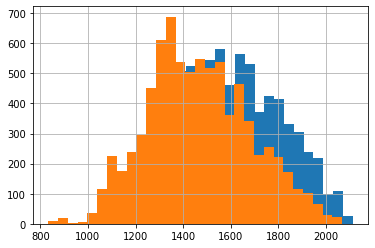

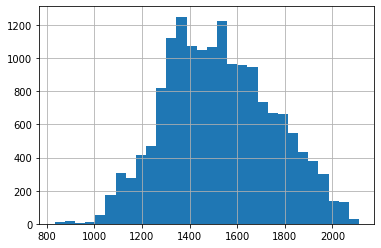

In [1162]:
a = train_for_2015_elo.loc[train_for_2015_elo['lower_win'] == 0.0]
b = train_for_2015_elo.loc[train_for_2015_elo['lower_win'] == 1.0]
fig,ax = plt.subplots()
a['higher_elo'].hist(bins=30)
b['higher_elo'].hist(bins=30)
fig,ax = plt.subplots()
train_for_2015_elo['higher_elo'].hist(bins=30)

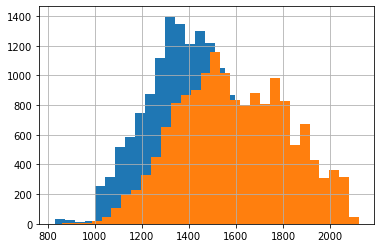

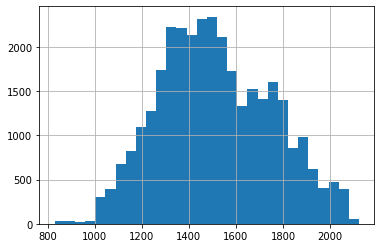

In [1439]:
a = train_for_2018_elo.loc[train_for_2018_elo['lower_win'] == 0.0]
b = train_for_2018_elo.loc[train_for_2018_elo['lower_win'] == 1.0]
fig,ax = plt.subplots()
a['lower_elo'].hist(bins=30)
b['lower_elo'].hist(bins=30)
fig,ax = plt.subplots()
train_for_2018_elo['lower_elo'].hist(bins=30)

*Next up let's take a look at OEff_diff and DEff_diff*

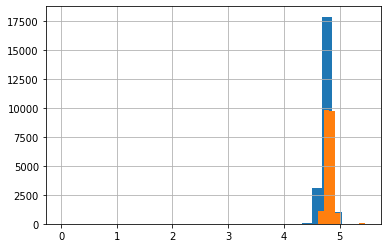

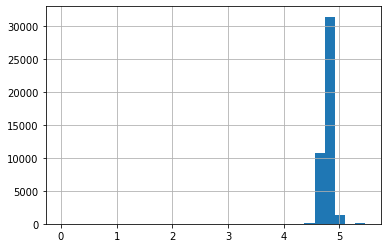

In [1451]:
l = train_for_2015_all.loc[train_for_2015_all['lower_win'] == 0.0]
w = train_for_2015_all.loc[train_for_2015_all['lower_win'] == 1.0]
fig,ax = plt.subplots()
l['log'].hist(bins=30)
w['log'].hist(bins=30)
fig,ax = plt.subplots()
train_for_2015_all['log'].hist(bins=30)

***Now we figured out that both distributions are pretty much normal but we would also apply log transform just to reassure that***

In [1501]:
train_for_2015_all

,ID,lower_win,seed_diff,lower_elo,higher_elo,OEff_diff,DEff_diff
0,2010_1143_1293,1.0,-5.0,1769.203473,1507.635282,0.2,8.9
1,2010_1198_1314,0.0,0.0,1350.442032,2131.479004,-6.0,12.2
2,2010_1108_1326,0.0,-2.0,1035.815934,1860.088983,-34.0,15.3
3,2010_1107_1393,0.0,-1.0,1364.162567,1903.931313,-19.5,11.2
4,2010_1143_1178,1.0,8.0,1770.783743,1344.007965,12.2,2.4
...,...,...,...,...,...,...,...
62,2014_1203_1272,0.0,1.0,1692.843075,1863.736441,-0.5,-0.6
63,2014_1235_1300,1.0,-11.0,1906.870975,1518.689145,1.5,9.4
64,2014_1235_1314,1.0,-3.0,1906.870975,1955.047144,4.3,2.3
65,2014_1184_1242,0.0,13.0,1564.625126,2034.916304,-0.2,5.0


In [1502]:
for df in [train_for_2015_all, train_for_2016_all, train_for_2017_all, train_for_2018_all, train_for_2019_all]:
    df['OEff_diff_tmp'] = df['OEff_diff']
    df['DEff_diff_tmp'] = df['DEff_diff']
    df['OEff_diff'] = round((df['OEff_diff']-df['OEff_diff'].min()+1) .transform(np.log),2)
    df['DEff_diff'] = round((df['DEff_diff']-df['DEff_diff'].min()+1) .transform(np.log),2)

In [1503]:
train_for_2017_all

,ID,lower_win,seed_diff,lower_elo,higher_elo,OEff_diff,DEff_diff,OEff_diff_tmp,DEff_diff_tmp
0,2012_1112_1434,1.0,0.0,1849.916599,1583.426710,4.81,4.73,2.9,-6.0
1,2012_1184_1280,0.0,0.0,1381.535697,1728.378594,4.74,4.83,-5.4,5.8
2,2012_1385_1456,1.0,0.0,1818.710289,1435.766195,4.83,4.74,4.6,-4.9
3,2012_1103_1280,1.0,0.0,1675.737364,1710.914047,4.77,4.75,-2.4,-4.1
4,2012_1112_1182,1.0,0.0,1852.396476,1668.340063,4.81,4.71,2.6,-7.9
...,...,...,...,...,...,...,...,...,...
62,2016_1320_1400,1.0,5.0,1757.089453,1837.500656,4.78,4.75,-0.7,-3.2
63,2016_1276_1323,0.0,5.0,1800.634963,1874.145339,4.76,4.73,-3.8,-5.5
64,2016_1323_1372,1.0,-8.0,1874.145339,1794.248022,4.80,4.90,0.9,15.5
65,2016_1323_1458,1.0,-1.0,1874.145339,1949.053722,4.86,4.84,8.5,7.4


In [1485]:
pred_2015

,ID,lower_elo,higher_elo,seed_diff,OEff_diff,DEff_diff
0,2015_1437_1438,2031.87,2048.15,-1.0,6.5,7.7
1,2015_1328_1437,1916.23,2031.87,2.0,-13.1,-2.7
2,2015_1257_1437,1999.25,2031.87,3.0,-13.2,-4.0
3,2015_1320_1437,1811.83,2031.87,4.0,-4.9,-0.2
4,2015_1344_1437,1823.86,2031.87,5.0,-11.0,5.8
...,...,...,...,...,...,...
2273,2015_1217_1411,1685.09,1439.85,-2.0,-2.4,-9.5
2274,2015_1157_1217,1447.03,1685.09,3.0,7.3,6.3
2275,2015_1209_1411,1662.78,1439.85,-1.0,5.6,-6.2
2276,2015_1157_1209,1447.03,1662.78,2.0,-0.7,3.0
